<h1>Challenge 3: Anomaly detection</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>
<i>May 2019</i>

In [1]:
!pip3 install --user 'scikit-multilearn' 
!pip3 install --user 'fim'
!pip3 install --user 'pysbrl'

You are using pip version 18.0, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.0, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.0, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Introduction
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

In this notebook we explore an anomaly detection (AD) problem. AD refers to the refers to the process of detecting data points that do not conform with the rest of observations. Usually AD implies an unsupervised learning problem, however we will approach the problem in a slightly different manner. 

We will be using data generated by an IT monitoring system. The input data has 36 columns, and the aim is to predict the outcome of 8 different "checks" (anomalies). A big challenge in this task has been handling missing data in the dataset, and the uneven distribution of anomalies versus "regular observations", but this are very typical problems in AD. 

In this notebook we will explore the distribution of the data we are working on, we will discuss a couple of ways of dealing with missing data. We will explore one rule-based model, that generates rules from training data, and uses them to predict the outcome of the test data. We will explore two different machine learning models. One using an ensamble of single-label classification models and one multilabel classification model. 

The models will be evalueated with the following metrics
* Predictive performance
* Interpretability
* Time it takes to train model

## Data exploration
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### Importing libraries and fetching data

In [2]:
# Elementary
import os
import sys
import re
import random
import matplotlib
import implicit
import warnings
from tqdm import tqdm
from time import time

# For elementary data manipulation
import pandas as pd
import numpy as np

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Import dataframe and cast names
from names import column_names, labels
basepath = "/mnt/datasets/anomaly/"
dataDF = pd.read_csv(basepath + 'data.csv', delimiter=";", header=None, names=column_names)
pure_dataDF = dataDF.drop(labels, axis=1)
anomaliesDF = dataDF.filter(labels, axis=1)

Let us first inspect what data is missing from the dataset. We first look at the missing data in the label dataframe (anamoliesDF), then the missing data in the input dataframe (pure_dataDF). 

In [4]:
print(anomaliesDF.isna().mean().round(4) * 100, '\n')
data_nan = pure_dataDF.isna().mean().round(4) * 100

nan_cols = []
for index, value in data_nan.iteritems():
    if value > 0:   
        print('{:<27} {:<10}'.format(index, np.round(value,2)))
        nan_cols.append(index)

Check1     8.54
Check2     8.53
Check3     7.86
Check4    12.77
Check5    12.21
Check6     2.57
Check7    12.45
Check8     0.02
dtype: float64 

CPU                         8.78      
PhysMEM                     7.17      
InstanceMEM                 7.71      
TablesAllocation            0.8       
IndexServerAllocationLimit  9.21      
DeltaSize                   0.07      
MergeErrors                 2.69      
BlockingPhaseSec            26.43     
Disk                        3.96      
LargestTableSize            5.66      
LargestPartitionSize        0.05      
DiagnosisFiles              7.64      
DiagnosisFilesSize          7.64      
LogSegmentChange            12.39     


Here we see that three of the checks have up to 13% of the data as NaN, or "missing", which is a lot. In the pure_dataDF there are only 14 columns with missing data, where two of them are missing 12% and 26% respectively, and the rest are missing between 0% and 8%. 

In [5]:
data_nan = pure_dataDF[nan_cols].copy()
data_nan.describe()

,CPU,PhysMEM,InstanceMEM,TablesAllocation,IndexServerAllocationLimit,DeltaSize,MergeErrors,BlockingPhaseSec,Disk,LargestTableSize,LargestPartitionSize,DiagnosisFiles,DiagnosisFilesSize,LogSegmentChange
count,261822.000000,2.664640e+05,264914.000000,284741.000000,260587.000000,2.868250e+05,279298.000000,2.111770e+05,2.756520e+05,2.707810e+05,2.868810e+05,265108.000000,2.651080e+05,251482.000000
mean,12.504883,1.992282e+02,47.683065,23.243752,50.252361,6.832394e+09,0.416469,3.559479e+03,7.423645e+10,2.933554e+08,3.349671e+08,250.991539,1.962630e+09,1.326023
std,20.605688,1.522155e+04,23.960828,17.889126,27.338611,1.176211e+10,0.492974,1.072371e+05,4.357427e+12,3.811502e+08,4.225627e+08,2640.173256,2.001116e+10,119.418179
min,0.120000,2.020000e+00,0.010000,0.000000,0.230000,0.000000e+00,0.000000,0.000000e+00,2.100000e-01,0.000000e+00,0.000000e+00,3.000000,1.514934e+06,-16887.000000
25%,2.950000,4.655000e+01,28.480000,8.630000,27.530000,1.666400e+09,0.000000,4.000000e+00,3.262000e+01,3.791122e+07,4.025581e+07,75.000000,4.286505e+08,0.000000
50%,6.460000,7.004000e+01,46.310000,20.490000,48.560000,3.718569e+09,0.000000,2.000000e+01,5.531000e+01,1.132627e+08,1.322221e+08,110.000000,7.328700e+08,0.000000
75%,14.900000,8.645000e+01,66.320000,35.000000,73.390000,9.471982e+09,1.000000,2.140000e+02,7.499000e+01,4.115236e+08,4.915097e+08,157.000000,1.261116e+09,0.000000
max,4602.490000,2.070680e+06,99.150000,94.600000,99.550000,1.280000e+12,1.000000,1.876111e+07,3.731038e+14,2.147484e+09,2.147484e+09,356265.000000,1.730000e+12,10084.000000


Without any description of what data is in the columns we can't be certain as to how we should handle missing data. We make some educated guesses as to what are in the columns: 'PhysMEM' could be the measure of available high memory at that moment, 'Disk' could be the available disk memory, etc. However we are not sure whether a NaN value in a particular column indicates that this column is not aplicable for this observation, but it could also mean that this value is missing for this observation.

We will explore to "extremes" of the these two scenarios. In one dataframe we will replace all the missing values with the average of the values not missing, here we assume that all the missing values were simply not recorded. In another dataframe we will replace all the NaN values with $-1$, here we assume that the NaNs indicate that this column is not valid for this observation. 

In [6]:
pure_dataDF_with_negNA = pure_dataDF.fillna(-1)
pure_dataDF_with_avgNA = pure_dataDF.fillna(pure_dataDF.mean())

In [7]:
print(pure_dataDF_with_negNA.isnull().any().any())
print(pure_dataDF_with_avgNA.isnull().any().any())

False
False


Now that we have handled the missing data in the input columns we take a look at the statistical properties of the anomaly-checks.

In [8]:
anomaliesDF.describe()

,Check1,Check2,Check3,Check4,Check5,Check6,Check7,Check8
count,262520.000000,262545.000000,264463.000000,250384.000000,251997.000000,279647.000000,251309.000000,286979.000000
mean,0.006232,0.033381,0.030602,0.099108,0.012222,0.288120,0.030592,0.010171
std,0.078696,0.179630,0.172236,0.298807,0.109877,0.452888,0.172209,0.100340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


This shows us that the anomalies are in general not very prevalant, and that the anomaly of highest occurency, is `Check6` with a 28% occurance rate, and the rarest is `Check1` which has a 0.62% occurance rate. The same information is shown more clearly below, and is illustrated with a figure. 

In [9]:
counted_anomaliesDF = anomaliesDF.apply(pd.value_counts)
counted_anomaliesDF.loc["Total"] = counted_anomaliesDF.sum()
counted_anomaliesDF.loc["OccuranceRate"] = (counted_anomaliesDF.iloc[1] / counted_anomaliesDF.iloc[2]).round(5)*100
pd.set_option('display.float_format', lambda x: '%.2f' % x)
counted_anomaliesDF

,Check1,Check2,Check3,Check4,Check5,Check6,Check7,Check8
0.0,260884.00,253781.00,256370.00,225569.00,248917.00,199075.00,243621.00,284060.00
1.0,1636.00,8764.00,8093.00,24815.00,3080.00,80572.00,7688.00,2919.00
Total,262520.00,262545.00,264463.00,250384.00,251997.00,279647.00,251309.00,286979.00
OccuranceRate,0.62,3.34,3.06,9.91,1.22,28.81,3.06,1.02


Text(0.5,1,'Observations with one or more anomalies')

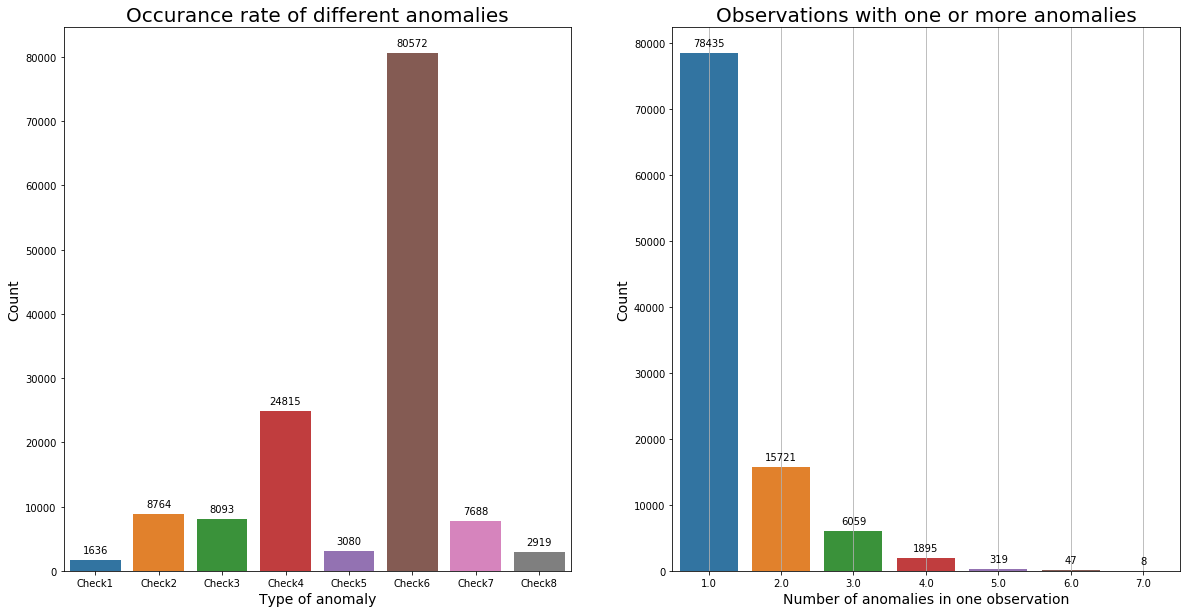

In [10]:
y1 = counted_anomaliesDF.loc[1.0]
x1 = labels

figure = plt.figure(figsize=(20,10))
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2)

b1 = sns.barplot(y=y1, x=x1, ax=ax1)
plt.grid()

for p in b1.patches:
    b1.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

rowSums = dataDF.iloc[:,36:].sum(axis=1)
rowSums = rowSums.value_counts()
multiLabel_counts = rowSums[1:]    

b2 = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values, ax=ax2)
plt.grid()

for p in b2.patches:
    b2.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax1.set_xlabel('Type of anomaly', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)
ax1.set_title('Occurance rate of different anomalies', fontsize=20)

ax2.set_xlabel('Number of anomalies in one observation', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)
ax2.set_title('Observations with one or more anomalies', fontsize=20)

Here we confirm the infomation retrieved from the description, and in addition we can see that there are relatively few observations that have more than one anomaly. That being said, lets have a look at the linear correlation between the different checks.

Text(0.5,1,'Corrolation matrix of the 8 different checks')

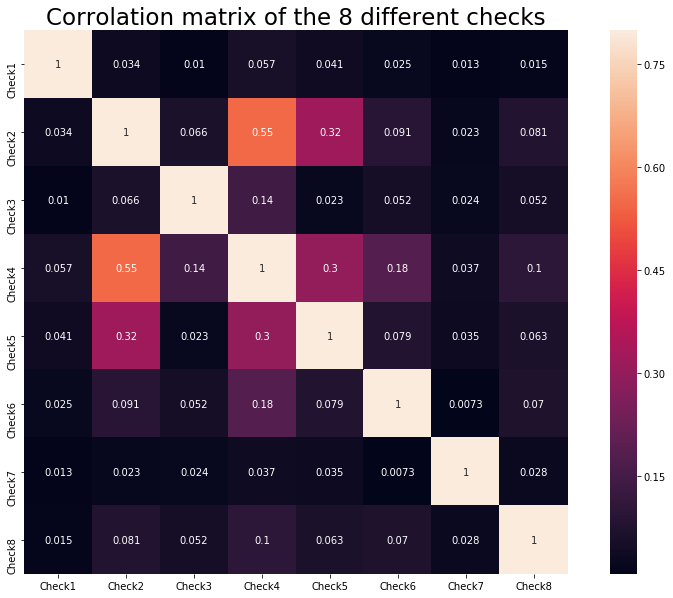

In [11]:
corr_matrix_anomalies = anomaliesDF.corr()
figure, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix_anomalies, vmax=0.8, annot=True, square=True)
plt.title('Corrolation matrix of the 8 different checks', fontsize=23)

From the correlation matrix, we can note three interesting dependencies. 
* Check4 and Check2 have a corrolation of 0.55. 
* Check5 and Check2 have a corrolation of 0.32.
* Check5 and Check4 have a corrolation of 0.3
This might come into play later, as we could check the effect of using the different checks to predict each other. For now we move on to cleaning of the input data. 

Let us take a look at the correlation between the different columns in the input data. We will come back to why we drop certain columns later, in the pre-processing section. 

Text(0.5,1,'Corrolation matrix of the input columns')

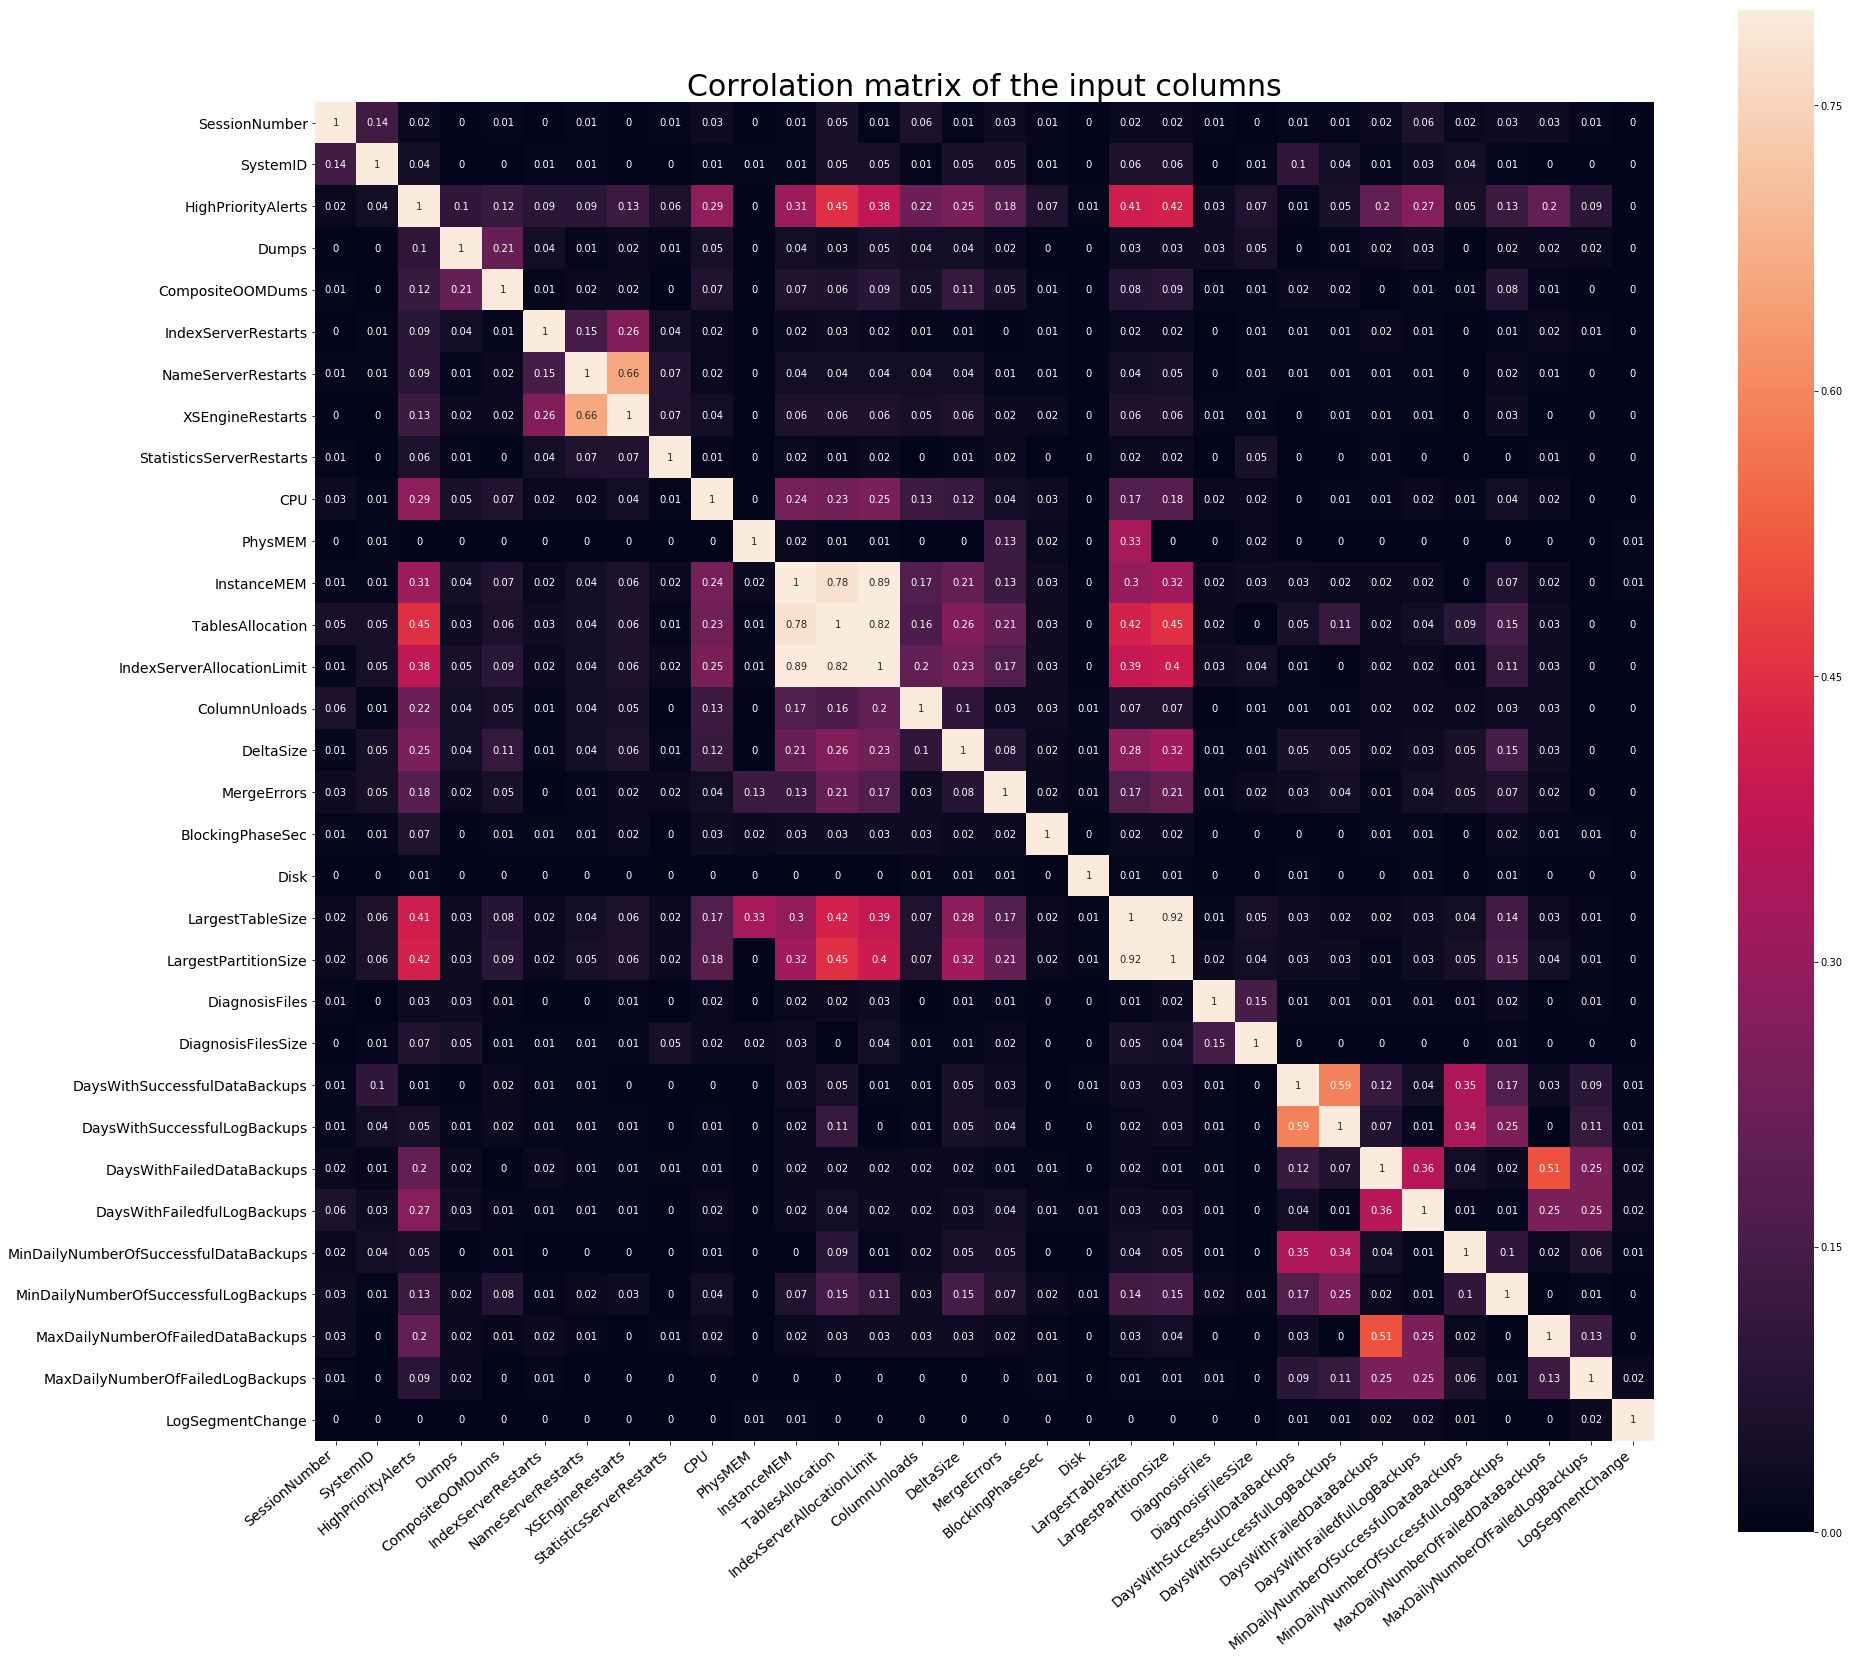

In [12]:
corr_matrix_data = pure_dataDF.drop(['Date', 
                                     'CleanupOOMDumps', 
                                     'PreprocessorRestarts', 
                                     'DaemonRestarts'], axis=1).corr().round(2)

figure, ax = plt.subplots(figsize=(30,28))
ax = sns.heatmap(abs(corr_matrix_data), vmax=0.8, annot=True, square=True)
ax.set_xticklabels(labels=corr_matrix_data.columns, rotation=40, ha='right')

for x_tick in ax.xaxis.get_major_ticks():
    x_tick.label.set_fontsize(14)

for y_tick in ax.yaxis.get_major_ticks():
    y_tick.label.set_fontsize(14)
plt.title('Corrolation matrix of the input columns', fontsize=30)

Here it is worth noting that many of the input columns are higly correlated. We will not go through all of the columns that are significantly correlated, but we will note the pairs that have a correlation above 50%.

* LargestTableSize and LargestPartitionSize are 92% correlated
* IndexServerAllocationLimit and InstanceMEM are 89% correlated
* InstanceMEM and TablesAllocation are 78% correlated
* NameServerRestarts and XSEngineRestarts are 66% correlated
* IndexServerAllocationLimit and TablesAllocation are 82% correlated
* DaysWithSuccessfulLogBackups and DaysWithSuccessfulDataBackups are 59% correlated

Finally we investigate whether there are any of the input columns that are particularily correlated with the different anomalies.

In [13]:
only_check1 = ['Check2', 'Check3', 'Check4', 'Check5', 'Check6', 'Check7', 'Check8']
only_check2 = ['Check1', 'Check3', 'Check4', 'Check5', 'Check6', 'Check7', 'Check8'] 
only_check3 = ['Check1', 'Check2', 'Check4', 'Check5', 'Check6', 'Check7', 'Check8'] 
only_check4 = ['Check1', 'Check2', 'Check3', 'Check5', 'Check6', 'Check7', 'Check8'] 
only_check5 = ['Check1', 'Check2', 'Check3', 'Check4', 'Check6', 'Check7', 'Check8'] 
only_check6 = ['Check1', 'Check2', 'Check3', 'Check4', 'Check5', 'Check7', 'Check8'] 
only_check7 = ['Check1', 'Check2', 'Check3', 'Check4', 'Check5', 'Check6', 'Check8'] 
only_check8 = ['Check1', 'Check2', 'Check3', 'Check4', 'Check5', 'Check6', 'Check7'] 

to_make_corr = dataDF.drop(['Date', 'CleanupOOMDumps', 'PreprocessorRestarts', 'DaemonRestarts'], axis=1)

nr_cols = 10
corr_check1 = to_make_corr.drop(only_check1, axis=1).corr(method='pearson')['Check1'].sort_values(ascending=False)[1:nr_cols]
corr_check2 = to_make_corr.drop(only_check2, axis=1).corr(method='pearson')['Check2'].sort_values(ascending=False)[1:nr_cols]
corr_check3 = to_make_corr.drop(only_check3, axis=1).corr(method='pearson')['Check3'].sort_values(ascending=False)[1:nr_cols]
corr_check4 = to_make_corr.drop(only_check4, axis=1).corr(method='pearson')['Check4'].sort_values(ascending=False)[1:nr_cols]
corr_check5 = to_make_corr.drop(only_check5, axis=1).corr(method='pearson')['Check5'].sort_values(ascending=False)[1:nr_cols]
corr_check6 = to_make_corr.drop(only_check6, axis=1).corr(method='pearson')['Check6'].sort_values(ascending=False)[1:nr_cols]
corr_check7 = to_make_corr.drop(only_check7, axis=1).corr(method='pearson')['Check7'].sort_values(ascending=False)[1:nr_cols]
corr_check8 = to_make_corr.drop(only_check8, axis=1).corr(method='pearson')['Check8'].sort_values(ascending=False)[1:nr_cols]

Text(0.5,1,'Correlation of different columns with Check4')

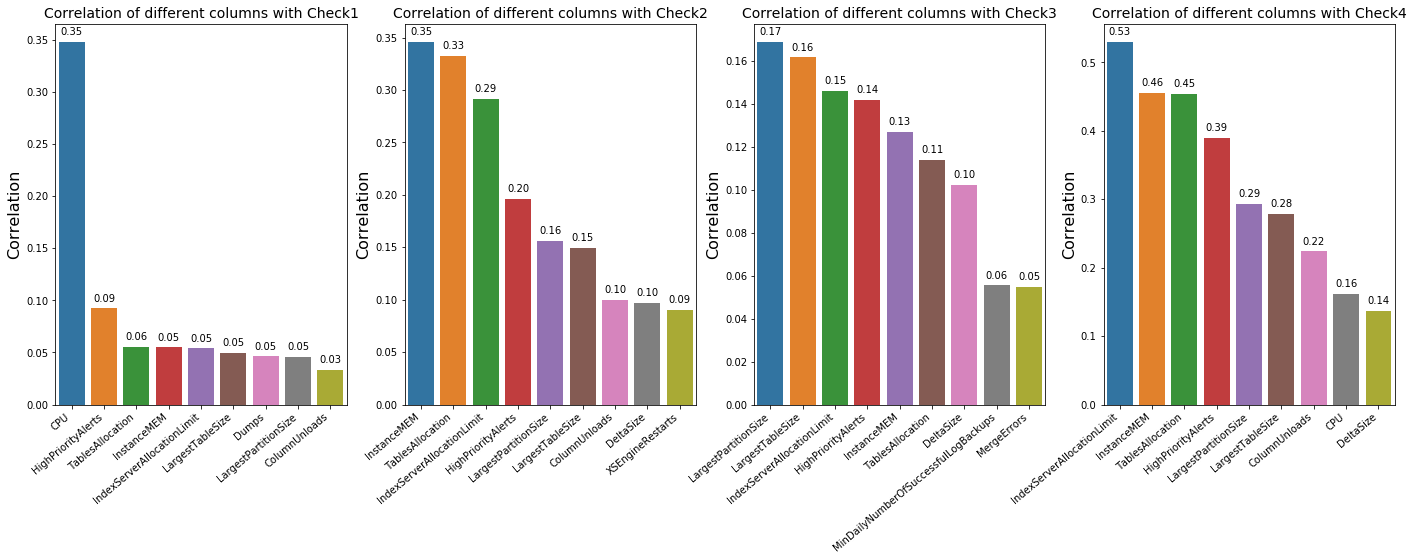

In [14]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(3*8,7))

sns.barplot(x=corr_check1.index, y=corr_check1.values, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right")
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

sns.barplot(x=corr_check2.index, y=corr_check2.values, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right")
for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
sns.barplot(x=corr_check3.index, y=corr_check3.values, ax=ax3)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=40, ha="right")
for p in ax3.patches:
    ax3.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
sns.barplot(x=corr_check4.index, y=corr_check4.values, ax=ax4)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=40, ha="right")
for p in ax4.patches:
    ax4.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

#ax1.set_xlabel('Column', fontsize= 16)
ax1.set_ylabel('Correlation', fontsize= 16)
ax1.set_title('Correlation of different columns with Check1', fontsize=14)

#ax2.set_xlabel('Column', fontsize= 16)
ax2.set_ylabel('Correlation', fontsize= 16)
ax2.set_title('Correlation of different columns with Check2', fontsize=14)

#ax3.set_xlabel('Column', fontsize= 16)
ax3.set_ylabel('Correlation', fontsize= 16)
ax3.set_title('Correlation of different columns with Check3', fontsize=14)

#ax4.set_xlabel('Column', fontsize= 16)
ax4.set_ylabel('Correlation', fontsize= 16)
ax4.set_title('Correlation of different columns with Check4', fontsize=14)

Text(0.5,1,'Correlation of different columns with Check8')

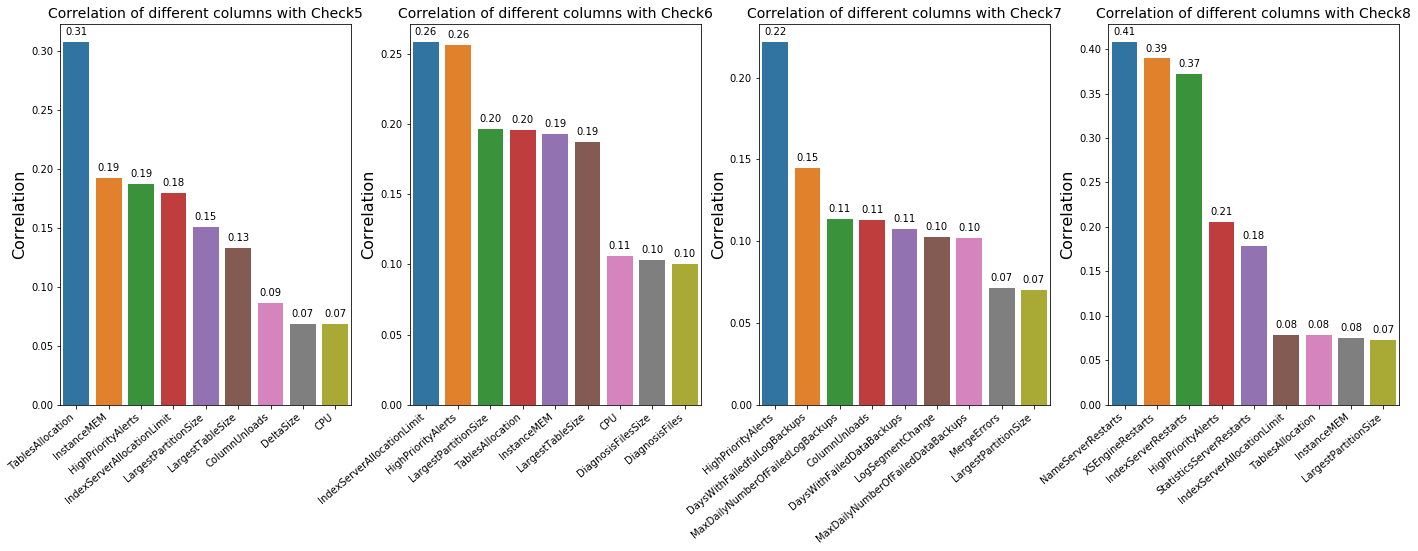

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(3*8,7))

sns.barplot(x=corr_check5.index, y=corr_check5.values, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right")
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

sns.barplot(x=corr_check6.index, y=corr_check6.values, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right")
for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
sns.barplot(x=corr_check7.index, y=corr_check7.values, ax=ax3)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=40, ha="right")
for p in ax3.patches:
    ax3.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
sns.barplot(x=corr_check8.index, y=corr_check8.values, ax=ax4)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=40, ha="right")
for p in ax4.patches:
    ax4.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

#ax1.set_xlabel('Column', fontsize= 16)
ax1.set_ylabel('Correlation', fontsize= 16)
ax1.set_title('Correlation of different columns with Check5', fontsize=14)

#ax2.set_xlabel('Column', fontsize= 16)
ax2.set_ylabel('Correlation', fontsize= 16)
ax2.set_title('Correlation of different columns with Check6', fontsize=14)

#ax3.set_xlabel('Column', fontsize= 16)
ax3.set_ylabel('Correlation', fontsize= 16)
ax3.set_title('Correlation of different columns with Check7', fontsize=14)

#ax4.set_xlabel('Column', fontsize= 16)
ax4.set_ylabel('Correlation', fontsize= 16)
ax4.set_title('Correlation of different columns with Check8', fontsize=14)

The following summary shows the most interesting stats:

`Check1`: Even though it is the anomaly with the lowest occurance rate, it has a surprisingly high correlation with the CPU column of 35%.

`Check2`: Has a correlation of approximately 30% with InstanceMEM, TablesAllocation and IndexServerAllocationLimit.

`Check3`: No particularily high correlation with any column (none above 20%). Could be hard to acheive any good accuracy on this anomaly.

`Check4`: 53% correlation with IndexServerAllocation, 45% correlation with InstanceMEM and TablesAllocation, 40% correlation with HighPrirorityAlerts and 30% correlation with LargestPartitionSize and LargestTableSize.

`Check5`: 31% correlation with TablesAllocation.

`Check6`: 26% correlation with IndexServerAllocationLimit and HighPriorityAlerts.

`Check7`: 22% correlation with HighPriorityAlerts.

`Check8`: Approxmately 40% correlation with NameServerRestarts, XSEngineRestarts and IndexServerRestarts.

This is interesting because, later we will show that the columns IndexServerRestarts, NameServerRestarts and XSEngineRestarts have quite low variance. But, still they have a high correlation with anomaly `Check8`.

## Data pre-processing
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

We take a look at the datatypes in the different columns.

In [16]:
pure_dataDF_with_avgNA.dtypes

SessionNumber                              int64
SystemID                                   int64
Date                                      object
HighPriorityAlerts                         int64
Dumps                                    float64
CleanupOOMDumps                          float64
CompositeOOMDums                         float64
IndexServerRestarts                        int64
NameServerRestarts                         int64
XSEngineRestarts                           int64
PreprocessorRestarts                       int64
DaemonRestarts                             int64
StatisticsServerRestarts                   int64
CPU                                      float64
PhysMEM                                  float64
InstanceMEM                              float64
TablesAllocation                         float64
IndexServerAllocationLimit               float64
ColumnUnloads                              int64
DeltaSize                                float64
MergeErrors         

In [17]:
pure_dataDF_with_avgNA.describe()

,SessionNumber,SystemID,HighPriorityAlerts,Dumps,CleanupOOMDumps,CompositeOOMDums,IndexServerRestarts,NameServerRestarts,XSEngineRestarts,PreprocessorRestarts,...,DiagnosisFilesSize,DaysWithSuccessfulDataBackups,DaysWithSuccessfulLogBackups,DaysWithFailedDataBackups,DaysWithFailedfulLogBackups,MinDailyNumberOfSuccessfulDataBackups,MinDailyNumberOfSuccessfulLogBackups,MaxDailyNumberOfFailedDataBackups,MaxDailyNumberOfFailedLogBackups,LogSegmentChange
count,287031.00,287031.00,287031.00,287031.00,287031.00,287031.00,287031.00,287031.00,287031.00,287031.00,...,287031.00,287031.00,287031.00,287031.00,287031.00,287031.00,287031.00,287031.00,287031.00,287031.00
mean,121660.35,634.39,2.80,0.72,0.00,0.17,0.10,0.06,0.05,0.00,...,1962629814.20,5.92,7.68,0.20,0.55,0.99,121.92,0.11,81.02,1.33
std,63902.08,686.66,2.69,12.07,0.00,1.91,1.92,1.19,1.03,0.00,...,19231772740.01,2.72,2.25,0.86,1.53,0.44,144.41,0.47,872.70,111.78
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1514934.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-16887.00
25%,67071.50,106.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,451848876.00,5.00,8.00,0.00,0.00,1.00,36.00,0.00,0.00,0.00
50%,130982.00,340.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,795133287.00,7.00,8.00,0.00,0.00,1.00,102.00,0.00,0.00,0.00
75%,174661.50,958.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1511461843.50,8.00,8.00,0.00,0.00,1.00,134.00,0.00,0.00,0.00
max,228195.00,3187.00,24.00,1429.00,0.00,280.00,341.00,159.00,150.00,0.00,...,1730000000000.00,14.00,22.00,13.00,14.00,17.00,7156.00,63.00,66017.00,10084.00


In the description we can note some strange numbers. A couple of columns have zero variance (e.g. CleanupOOMDumps), meaning that they only contain zeros or NaNs. These will not be usefull for the model, and are therefore removed. Some of the columns have a very low variance meaning that they contain very little data. Some of the columns are in float format, and our rule based model requires them to be integers, so we need to recast them to integers with some preprocessing first.

Below is the code used to analyze every column (we only show one example), and the table in the cell below shows the action we take for each column.

In [18]:
sing_ser = pure_dataDF['DeltaSize']

indices_of_non_zero_elements = list(sing_ser.index[np.logical_and(sing_ser != 0.0, sing_ser != np.nan)])
to_inspect = sing_ser[indices_of_non_zero_elements]

print('Number of non-zero elements:',len(to_inspect), '\n')
start = 100
print(to_inspect[start:start + 5])

Number of non-zero elements: 286677 

100   9596538169.00
101   1787984069.00
102   1496695469.00
103   9569578911.00
104   2575048775.00
Name: DeltaSize, dtype: float64


Below are some short explainations of the different actions, and the table showing which action is taken for the different columns:
* **Remove**: Only zeros and NaNs, do not contribute to model
* **Little_variation**: Little variation in data, may not contribute much to model. The reason for not removing them is that even though they don't vary a lot, they might still be correlated with the different anomalies.
* **OK**: Can't see anything obviously suspect with the data, and no need for recasting for rule-based model.
* **Direct_recast**: All the numbers are integers, but for some reason they have been casted to float64
* **Format_recast** Values are float or string, and need to be scaled/formatted before they are recast to int

| Column                                |   Action  |
|:--------------------------------------|:----------|
| SessionNumber                         | OK |
| SystemID                              | OK |
| Date                                  | Remove |
| HighPriorityAlerts                    | OK |
| Dumps                                 | Direct_recast |
| CleanupOOMDumps                       | Remove |
| CompositeOOMDums                      | Direct_recast |
| IndexServerRestarts                   | Little_variation |
| NameServerRestarts                    | Little_variation |
| XSEngineRestarts                      | Little_variation |
| PreprocessorRestarts                  | Remove |
| DaemonRestarts                        | Remove |
| StatisticsServerRestarts              | Little_variation |
| CPU                                   | Format_recast |
| PhysMEM                               | Format_recast |
| InstanceMEM                           | Format_recast |
| TablesAllocation                      | Format_recast |
| IndexServerAllocationLimit            | Format_recast |
| ColumnUnloads                         | OK |
| DeltaSize                             | Direct_recast |
| MergeErrors                           | Direct_recast |
| BlockingPhaseSec                      | Direct_recast |
| Disk                                  | Format_recast |
| LargestTableSize                      | Direct_recast |
| LargestPartitionSize                  | Direct_recast |
| DiagnosisFiles                        | Direct_recast |
| DiagnosisFilesSize                    | Direct_recast |
| DaysWithSuccessfulDataBackups         | OK |
| DaysWithSuccessfulLogBackups          | OK |
| DaysWithFailedDataBackups             | OK |
| DaysWithFailedfulLogBackups           | OK |
| MinDailyNumberOfSuccessfulDataBackups | Little_variation |
| MinDailyNumberOfSuccessfulLogBackups  | OK |
| MaxDailyNumberOfFailedDataBackups     | OK |
| MaxDailyNumberOfFailedLogBackups      | OK |
| LogSegmentChange                      | Direct_recast |

Below we reformat, and recast the columns listed in the table above. When recasting the columns in format float64 we round them to two decimals and multiply by 100. The column "Date" is in a timestamp format, we decided to remove it because the time of day was almost always the same in the different observations. It could have been interesting to see if a particular week day had many more anomalies, but it was a bit to cumbersome to implement. Below we preprocess the columns.

In [19]:
# Removal
pure_dataDF_with_avgNA_proc = pure_dataDF_with_avgNA.drop(['Date', 
                                                           'CleanupOOMDumps', 
                                                           'PreprocessorRestarts', 
                                                           'DaemonRestarts'], axis=1)

pure_dataDF_with_negNA_proc = pure_dataDF_with_negNA.drop(['Date', 
                                                           'CleanupOOMDumps', 
                                                           'PreprocessorRestarts', 
                                                           'DaemonRestarts'], axis=1)

# Direct recasting
direct_recast = ['Dumps', 'CompositeOOMDums', 'DeltaSize', 'MergeErrors', 'BlockingPhaseSec', 
                 'LargestTableSize', 'LargestPartitionSize', 'DiagnosisFiles', 'DiagnosisFilesSize', 
                 'LogSegmentChange']

for column in direct_recast:
    pure_dataDF_with_avgNA_proc[column] = pure_dataDF_with_avgNA_proc[column].astype(np.int64, errors='ignore')
    pure_dataDF_with_negNA_proc[column] = pure_dataDF_with_negNA_proc[column].astype(np.int64, errors='ignore')

#Format recasting
format_recast = ['CPU', 'PhysMEM', 'InstanceMEM', 'TablesAllocation', 'IndexServerAllocationLimit', 
                    'Disk']
for column in format_recast:
    pure_dataDF_with_avgNA_proc[column] = 100*pure_dataDF_with_avgNA_proc[column]
    pure_dataDF_with_avgNA_proc[column] = pure_dataDF_with_avgNA_proc[column].astype(np.int64, errors='ignore')
    
    pure_dataDF_with_negNA_proc[column] = 100*pure_dataDF_with_negNA_proc[column]
    pure_dataDF_with_negNA_proc[column] = pure_dataDF_with_negNA_proc[column].astype(np.int64, errors='ignore')

pure_dataDF_with_avgNA_proc.dtypes

SessionNumber                            int64
SystemID                                 int64
HighPriorityAlerts                       int64
Dumps                                    int64
CompositeOOMDums                         int64
IndexServerRestarts                      int64
NameServerRestarts                       int64
XSEngineRestarts                         int64
StatisticsServerRestarts                 int64
CPU                                      int64
PhysMEM                                  int64
InstanceMEM                              int64
TablesAllocation                         int64
IndexServerAllocationLimit               int64
ColumnUnloads                            int64
DeltaSize                                int64
MergeErrors                              int64
BlockingPhaseSec                         int64
Disk                                     int64
LargestTableSize                         int64
LargestPartitionSize                     int64
DiagnosisFile

### Splitting dataset, while retaining label distribution

When splitting the data set into train, validate and test sets it was important that we retained the distribution of the different anomalies. For the cases where we looked at an ensamble of single-label classification models this was fairly straight forward, but for the multi-label classification model this was quite challenging. As mentioned before, many of the observations in the anomaliesDF are noted as NaN, so part of the question is what do we do with the NaN values. There are four options as far as we can see.

1. We can disregard the NaN values and only use the labeled elements in the different anomaly series. This can work for the single-label classification models, each classification model, only has to disregard the NaN values in one column. However, the multi-label classification model would have to disregard any row with at least one NaN value, this would mean the model has to disregard roughly 40% of the data.

2. We can regard the NaNs in each column as 0, or "not an anomaly". 

3. We can regard the NaNs in each column as 1 or "an anomaly". 

4. We can change the NaN values to something other than 0 or 1, making each column a multi-class classification problem. This way we consider the NaN value to indicate that this row is "Not applicable for this observation". 

In this notebook we will explore the 1. and 2. option. Below are functions we use to remove the rows corresponding to NaN values in a particular "Check" column, and a function we use to split the data set into train, validation and test sets.

In [20]:
anomaliesDF_with_negNA = anomaliesDF.fillna(-1)
anomaliesDF_with_zerNA = anomaliesDF.fillna(0)

def create_binary_classification(puredataDF, anomaliesDF, label):
    y = anomaliesDF[label]
    indices_nan_labels = list(y.index[y.isnull()])
    
    X_mod = puredataDF.drop(indices_nan_labels, axis=0)
    y_mod = y.drop(indices_nan_labels)
    y_mod = y_mod.astype(np.int64, errors='raise')
    
    X_mod = X_mod.reset_index().drop("index", axis=1)
    y_mod = y_mod.reset_index().drop("index", axis=1)
    return X_mod, y_mod

from sklearn.model_selection import StratifiedShuffleSplit

# This function splits the dataset into 0.6 train, 0.2 val and 0.2 test sets ONLY SINGLE LABEL
def train_val_test_split(X, y, seed):
    # This generator splits the original dataset into train and test sets
    sss_train_test = StratifiedShuffleSplit(n_splits = 1, 
                                   test_size = 0.2, 
                                   train_size = 0.8, 
                                   random_state = seed)

    # This generator splits the newly created train-set into train and validate sets
    sss_train_val = StratifiedShuffleSplit(n_splits = 1, 
                                   test_size = 0.25, 
                                   train_size = 0.75, 
                                   random_state = seed)

    for train_index, test_index in sss_train_test.split(X,y):
        X_temp = X.iloc[train_index, :]
        y_temp = y.iloc[train_index, :]
        X_test = X.iloc[test_index, :]
        y_test = y.iloc[test_index, :]

    for train_index, test_index in sss_train_val.split(X_temp,y_temp):
        X_train = X_temp.iloc[train_index, :]
        y_train = y_temp.iloc[train_index, :]
        X_val = X_temp.iloc[test_index, :]
        y_val = y_temp.iloc[test_index, :]
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_temp, y_temp

For the multi-label classification model we were not able to split the dataframe in a way that preserved the distribution of the labels. Just because there are so many scarce distributions to retain. So we simply use train_test_split from sklearn. To get the dataframe in the format that the rule-based model requires, we needed use a function from the pysbrl library to convert the files to .out and .label format.

In [21]:
import pysbrl

# We block print becuase categorical2pysbrl_data prints out a lot of uninteresting data to stdout. 
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
        
# Save dataframes to the format the SBRL library requires
def format_dataframe(X, y, file_X, file_y):
    # Convert to numpy ndarray
    _X = X.values
    _y = y.values[:,0]
    
    name_X = file_X + '.out'
    name_y = file_y + '.label'
    
    with HiddenPrints():
        pysbrl.utils.categorical2pysbrl_data(_X,
                                            _y,
                                            name_X,
                                            name_y,
                                            method='eclat',
                                            supp=0.05,
                                            zmin=1,
                                            zmax=3)

The pysbrl train-function returns a list of rules, and probabilities, but to get them in a readable formate we create a function that links the index of the column (that the pysbrl library uses) to the name of the column in the dataframe.

In [22]:
from IPython.display import display, Markdown

def translate_output_to_text(rule_ids, outputs, rule_strings, filename, column_names, label, verbose):
    rules = [rule_strings[i] for i in rule_ids]
    split_rules = [rule[1:-1].split(',') for rule in rules[:-1]] # LAST RULE IS ONLY 'default'
    
    rules_with_column_names = []
    for num_rule in split_rules:
        rule_with_column_names = []
        for sub_rule in num_rule:
            col_number = int(sub_rule.split('=')[0][1:])
            col_name = column_names[col_number]
            new_sub_rule = col_name + '=' + sub_rule.split('=')[1]
            rule_with_column_names.append(new_sub_rule)
        rules_with_column_names.append(rule_with_column_names)
    
    to_return = rules_with_column_names.copy()
    
    f = open(filename,'w+')
    f.write('| Rule | $P(%s = 0)$ | $P(%s = 1)$ |\n' % (label, label))
    f.write('|:-----|:----------------|:----------------|\n')
    
    separator = ' and '
    for i in range(len(outputs[:-1])):
        rule_to_write = separator.join(rules_with_column_names[i])
        output = outputs[i]
        string_to_write = '| ' + rule_to_write + ' | %.5f | %.5f |' % (output[0], output[1]) + '\n'
        f.write(string_to_write)
    
    default_prob = outputs[-1]
    f.write('| Default | %.5f | %.5f |\n' % (default_prob[0], default_prob[1]))
    f.close()
    
    if verbose == True:
        with open(filename, 'r') as fh:
            content = fh.read()
        display(Markdown(content))
    
    return to_return

Finally we need a function to use the rules produced by the training to make predictions.

In [23]:
def check_rule(formatted_rule, row_series):
    pass_var = True
    for sub_rule in formatted_rule:
        if (row_series[sub_rule.split('=')[0]] != int(sub_rule.split('=')[1])):
            pass_var = False
            break
    return pass_var

def predict_row(formatted_rule_list, outputs, row_series):
    prediction = 7
    for i in range(len(formatted_rule_list)):
        if(check_rule(formatted_rule_list[i], row_series) == True):
            prediction = int(np.round(outputs[i,1]))
            break
    if prediction == 7:
        prediction = int(np.round(outputs[-1,1]))
    return prediction

def SBRL_predict(formatted_rule_list, outputs, X_test, y_test):
    y_pred = pd.Series(np.zeros(y_test.shape[0], dtype=int))
    for index, row_series in X_test.iterrows():
        y_pred.iloc[index] = predict_row(formatted_rule_list, outputs, row_series)
    return y_pred

Finally we combine all this together to one function, and add a couple of metrics to measure the performance of the model. As there is a great skewness in the available data in the different labels, we use the F1 score with equal weighting of the two labels, and look at the accuracy within the different labels. 

In [24]:
from sklearn.metrics import confusion_matrix, f1_score

def full_pipeline_SBRL(X, anomaliesDF, label, verbose):
    # REMOVING NANS -------------------------------------------------------------------------
    X, y = create_binary_classification(X, anomaliesDF, label)
    # SPLITTING INTO TRAIN, VAL & TEST ------------------------------------------------------
    X_train, y_train, X_val, y_val, X_test, y_test, X_train_big, y_train_big = train_val_test_split(X, y, 42)
    
    # REFORMATTING input_data ----------------------------------------------------------------
    t0 = time()
    if verbose == True:
        print('Reformatting')
    format_dataframe(X_train_big, y_train_big, 'file_X', 'file_y')
    t1 = time()
    # TRAINING SBRL MODEL --------------------------------------------------------------------
    if verbose == True:
        print('Reformatting the data took %.2f seconds' % (t1 - t0))
        print('Training SBRL model')
    t2 = time()

    # Using SBRL Library from https://github.com/myaooo/pysbrl
    rule_ids, outputs, rule_strings = pysbrl.train_sbrl('file_X.out', 
                                                        'file_y.label', 
                                                        20.0, 
                                                        eta=2.0, 
                                                        max_iters=2000) 
                                                        #nchain=10, 
                                                        #alphas=[1,1])
    
    t3 = time()
    if verbose == True:
        print('Training the SBRL based model took %.2f seconds' % (t3 - t2))
    
    # PRINTING DATA IN NICE FORMAT -------------------------------------------------------
    formatted_rule_list = translate_output_to_text(rule_ids=rule_ids, 
                                                     outputs=outputs, 
                                                     rule_strings=rule_strings, 
                                                     filename='function_rule_file.md', 
                                                     column_names=X_train.columns,
                                                     label=list(y_train.columns)[0],
                                                     verbose=verbose)
    
    # TESTING MODEL ----------------------------------------------------------------------
    test_data = X_test.reset_index().drop('index', axis=1)
    test_labels = y_test.reset_index().drop('index', axis=1)
    if verbose == True:
        print('Using model for predictions')
    y_pred = SBRL_predict(formatted_rule_list=formatted_rule_list, 
                          outputs=outputs, 
                          X_test=test_data, 
                          y_test=test_labels)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    f1 = f1_score(y_test, y_pred, average='macro')
    print('For anomaly', label)
    print('F1 Score acheived = %.2f' %(f1*100))
    print('Accuracy in 1s = %.2f' %(tp/(tp + fn)*100))
    print('Accuracy in 0s = %.5f' %(tn/(tn + fp)*100))
    print('\n')

### PCA and component normalization
We also want to see whether Principle component analysis, and normalization of the variables could make a difference in the performance of the machine learning. Below is the code we use to normalize and perform PCA.

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# PCA performs best with a normalized feature set 

def normalize_PCA(X_train, X_test, pca_value):
    sc = StandardScaler()  
    scaled_X_train = sc.fit_transform(X_train)  
    scaled_X_test = sc.transform(X_test)  
    
    pca = PCA(pca_value)  
    pca_X_train = pca.fit_transform(scaled_X_train)  
    pca_X_test = pca.transform(scaled_X_test) 
    
    return pca_X_train, pca_X_test

## Model Selection
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### Rule based model

Let us test this model on the `Check6` anomaly, as it is the most frequent. As input data we start using pure_dataDF_with_negNA, then test with pure_dataDF_with_avgNA. With regards to which anomaliesDF we use, we start using anomaliesDF, and disgard the NaNs, and then test using anomaliesDF_with_zerNA.

In [76]:
pure_dataDF_with_negNA_proc

full_pipeline_SBRL(X=pure_dataDF_with_negNA_proc, 
                   anomaliesDF=anomaliesDF, 
                   label='Check6', 
                   verbose=True)

Reformatting
Reformatting the data took 73.74 seconds
Training SBRL model
Training the SBRL based model took 64.15 seconds


| Rule | $P(Check6 = 0)$ | $P(Check6 = 1)$ |
|:-----|:----------------|:----------------|
| ColumnUnloads=0 and HighPriorityAlerts=4 and CompositeOOMDums=0 | 0.70234 | 0.29766 |
| ColumnUnloads=0 and BlockingPhaseSec=3 and StatisticsServerRestarts=0 | 0.85938 | 0.14062 |
| ColumnUnloads=0 and BlockingPhaseSec=1 and Dumps=0 | 0.86608 | 0.13392 |
| BlockingPhaseSec=2 and MaxDailyNumberOfFailedDataBackups=0 and Dumps=0 | 0.88048 | 0.11952 |
| MergeErrors=1 and HighPriorityAlerts=2 and Dumps=0 | 0.73014 | 0.26986 |
| ColumnUnloads=0 and HighPriorityAlerts=2 and XSEngineRestarts=0 | 0.77374 | 0.22626 |
| MinDailyNumberOfSuccessfulDataBackups=1 and HighPriorityAlerts=1 and Dumps=0 | 0.80200 | 0.19800 |
| DaysWithFailedDataBackups=0 and MinDailyNumberOfSuccessfulDataBackups=1 and HighPriorityAlerts=1 | 0.57087 | 0.42913 |
| MergeErrors=0 and HighPriorityAlerts=0 and LogSegmentChange=0 | 0.85260 | 0.14740 |
| HighPriorityAlerts=3 and MaxDailyNumberOfFailedLogBackups=0 and Dumps=0 | 0.70842 | 0.29158 |
| HighPriorityAlerts=3 and MaxDailyNumberOfFailedLogBackups=0 and LogSegmentChange=0 | 0.52929 | 0.47071 |
| DaysWithSuccessfulDataBackups=7 and HighPriorityAlerts=0 and LogSegmentChange=0 | 0.83850 | 0.16150 |
| MergeErrors=0 and DaysWithFailedDataBackups=0 and HighPriorityAlerts=3 | 0.77416 | 0.22584 |
| DiagnosisFiles=-1 and Dumps=0 | 0.50073 | 0.49927 |
| Dumps=1 and StatisticsServerRestarts=0 | 0.45566 | 0.54434 |
| HighPriorityAlerts=1 and LogSegmentChange=0 and CompositeOOMDums=0 | 0.81305 | 0.18695 |
| DaysWithSuccessfulLogBackups=8 and HighPriorityAlerts=3 and Dumps=0 | 0.71998 | 0.28002 |
| TablesAllocation=0 and Dumps=0 | 0.70638 | 0.29362 |
| MergeErrors=1 and HighPriorityAlerts=0 and Dumps=0 | 0.83554 | 0.16446 |
| IndexServerAllocationLimit=-100 and BlockingPhaseSec=-1 and CPU=-100 | 0.20264 | 0.79736 |
| DaysWithSuccessfulDataBackups=5 and DaysWithFailedDataBackups=0 and Dumps=0 | 0.69667 | 0.30333 |
| Dumps=0 and XSEngineRestarts=0 and CPU=-100 | 0.82524 | 0.17476 |
| MergeErrors=0 and Dumps=0 and XSEngineRestarts=0 | 0.64750 | 0.35250 |
| MaxDailyNumberOfFailedLogBackups=0 and Dumps=0 | 0.59402 | 0.40598 |
| DaysWithFailedDataBackups=0 and HighPriorityAlerts=3 and LogSegmentChange=0 | 0.67698 | 0.32302 |
| InstanceMEM=-100 and NameServerRestarts=0 and CPU=-100 | 0.58824 | 0.41176 |
| HighPriorityAlerts=5 and Dumps=0 and StatisticsServerRestarts=0 | 0.64888 | 0.35112 |
| BlockingPhaseSec=-1 and Dumps=0 and XSEngineRestarts=0 | 0.45755 | 0.54245 |
| BlockingPhaseSec=-1 and MinDailyNumberOfSuccessfulDataBackups=1 and LogSegmentChange=-1 | 0.17250 | 0.82750 |
| MinDailyNumberOfSuccessfulDataBackups=1 and HighPriorityAlerts=5 and StatisticsServerRestarts=0 | 0.34135 | 0.65865 |
| DiagnosisFilesSize=-1 and DaysWithSuccessfulLogBackups=8 and LogSegmentChange=0 | 0.15722 | 0.84278 |
| BlockingPhaseSec=-1 and MinDailyNumberOfSuccessfulDataBackups=1 and LogSegmentChange=0 | 0.20631 | 0.79369 |
| ColumnUnloads=0 and MinDailyNumberOfSuccessfulDataBackups=1 and Dumps=0 | 0.60240 | 0.39760 |
| DaysWithSuccessfulDataBackups=6 and MaxDailyNumberOfFailedDataBackups=0 and LogSegmentChange=0 | 0.16755 | 0.83245 |
| CompositeOOMDums=0 and IndexServerRestarts=0 and NameServerRestarts=0 | 0.42074 | 0.57926 |
| BlockingPhaseSec=-1 and DaysWithFailedDataBackups=0 and DaysWithFailedfulLogBackups=0 | 0.16429 | 0.83571 |
| HighPriorityAlerts=4 and NameServerRestarts=0 and XSEngineRestarts=0 | 0.47154 | 0.52846 |
| ColumnUnloads=0 and MergeErrors=1 and DaysWithSuccessfulDataBackups=7 | 0.39344 | 0.60656 |
| IndexServerAllocationLimit=-100 and DaysWithFailedDataBackups=0 | 0.15385 | 0.84615 |
| DaysWithSuccessfulLogBackups=8 and MaxDailyNumberOfFailedDataBackups=0 and LogSegmentChange=-1 | 0.61111 | 0.38889 |
| IndexServerRestarts=0 | 0.22494 | 0.77506 |
| Default | 0.35441 | 0.64559 |


Using model for predictions
For anomaly Check6
F1 Score acheived = 58.21
Accuracy in 1s = 21.48
Accuracy in 0s = 95.48411


So here we see that the SBRL system creates a massive rule set where each row is a specific rule. Tak the first row for example. It can be read like this.

If ColumnUnloads = 0 and HighPriorityAlerts = 4 and CompositeOOMDums = 0 the probability of check6 being zero is 0.70234 and the probability of check6 being 1 is 0.2976.

If this rule is not met, it will move down to the rule below, and if that rule is not met it will move down to the next rule, and so on. If none of the rules are met it will use the default rule using the general distribution of ones and zeros in the labels. the f1 score was suprisingly low considering this is the most evenly distributed anomaly. 

Let us check how well the model performs on the other anomalies.

In [28]:
checks = ['Check1', 'Check2', 'Check3', 'Check4', 'Check5', 'Check6', 'Check7', 'Check8']

In [82]:
for check in checks:
    full_pipeline_SBRL(X=pure_dataDF_with_negNA_proc, 
                   anomaliesDF=anomaliesDF, 
                   label=check, 
                   verbose=False)

For anomaly Check1
F1 Score acheived = 53.94
Accuracy in 1s = 4.28
Accuracy in 0s = 99.99808




/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For anomaly Check2
F1 Score acheived = 49.15
Accuracy in 1s = 0.00
Accuracy in 0s = 100.00000




/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For anomaly Check3
F1 Score acheived = 49.22
Accuracy in 1s = 0.00
Accuracy in 0s = 100.00000


For anomaly Check4
F1 Score acheived = 78.71
Accuracy in 1s = 57.12
Accuracy in 0s = 96.79922


For anomaly Check5
F1 Score acheived = 52.05
Accuracy in 1s = 2.44
Accuracy in 0s = 99.98795


For anomaly Check6
F1 Score acheived = 57.91
Accuracy in 1s = 21.17
Accuracy in 0s = 95.33593


For anomaly Check7
F1 Score acheived = 52.84
Accuracy in 1s = 3.84
Accuracy in 0s = 99.92201


For anomaly Check8
F1 Score acheived = 93.89
Accuracy in 1s = 82.02
Accuracy in 0s = 99.95247




Here we can see that the rule-based model performs very bad on `Check2` and `Check3` (zero correct predictions of ones), not very well on `Check1` `Check5`, or `Check7` (52 to 54 in F1-score), and surprisingly well in `Check4` and `Check8` where it achieved an F1-score of 79 and 94 respectively. Let us now see how the model performs on different combinations of input dataframes, and label-dataframes.

In [24]:
for check in checks:
    full_pipeline_SBRL(X=pure_dataDF_with_negNA_proc, 
                   anomaliesDF=anomaliesDF_with_zerNA, 
                   label=check, 
                   verbose=False)

For anomaly Check1
F1 Score acheived = 53.39
Accuracy in 1s = 3.67
Accuracy in 0s = 99.99825




/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For anomaly Check2
F1 Score acheived = 49.22
Accuracy in 1s = 0.00
Accuracy in 0s = 100.00000


For anomaly Check3
F1 Score acheived = 49.53
Accuracy in 1s = 0.25
Accuracy in 0s = 99.99104


For anomaly Check4
F1 Score acheived = 78.85
Accuracy in 1s = 60.21
Accuracy in 0s = 96.56967


For anomaly Check5
F1 Score acheived = 52.35
Accuracy in 1s = 2.76
Accuracy in 0s = 99.97183


For anomaly Check6
F1 Score acheived = 57.53
Accuracy in 1s = 19.66
Accuracy in 0s = 96.31163


For anomaly Check7
F1 Score acheived = 52.85
Accuracy in 1s = 3.71
Accuracy in 0s = 99.95525


For anomaly Check8
F1 Score acheived = 93.37
Accuracy in 1s = 79.28
Accuracy in 0s = 99.96656




In [25]:
for check in checks:
    full_pipeline_SBRL(X=pure_dataDF_with_avgNA_proc, 
                   anomaliesDF=anomaliesDF, 
                   label=check, 
                   verbose=False)

For anomaly Check1
F1 Score acheived = 53.94
Accuracy in 1s = 4.28
Accuracy in 0s = 99.99808




/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For anomaly Check2
F1 Score acheived = 49.15
Accuracy in 1s = 0.00
Accuracy in 0s = 100.00000


For anomaly Check3
F1 Score acheived = 49.28
Accuracy in 1s = 0.06
Accuracy in 0s = 99.99610


For anomaly Check4
F1 Score acheived = 78.74
Accuracy in 1s = 57.06
Accuracy in 0s = 96.82804


For anomaly Check5
F1 Score acheived = 52.06
Accuracy in 1s = 2.44
Accuracy in 0s = 99.99197


For anomaly Check6
F1 Score acheived = 57.64
Accuracy in 1s = 20.19
Accuracy in 0s = 96.12206


For anomaly Check7
F1 Score acheived = 53.39
Accuracy in 1s = 4.49
Accuracy in 0s = 99.89122


For anomaly Check8
F1 Score acheived = 94.77
Accuracy in 1s = 85.27
Accuracy in 0s = 99.94895




In [27]:
for check in checks:
    full_pipeline_SBRL(X=pure_dataDF_with_avgNA_proc, 
                   anomaliesDF=anomaliesDF_with_zerNA, 
                   label=check, 
                   verbose=False)

For anomaly Check1
F1 Score acheived = 53.66
Accuracy in 1s = 3.98
Accuracy in 0s = 99.99650




/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For anomaly Check2
F1 Score acheived = 49.22
Accuracy in 1s = 0.00
Accuracy in 0s = 100.00000




/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For anomaly Check3
F1 Score acheived = 49.28
Accuracy in 1s = 0.00
Accuracy in 0s = 100.00000


For anomaly Check4
F1 Score acheived = 77.99
Accuracy in 1s = 54.83
Accuracy in 0s = 97.21036


For anomaly Check5
F1 Score acheived = 52.10
Accuracy in 1s = 2.44
Accuracy in 0s = 99.99472


For anomaly Check6
F1 Score acheived = 59.56
Accuracy in 1s = 23.91
Accuracy in 0s = 94.63819


For anomaly Check7
F1 Score acheived = 63.20
Accuracy in 1s = 19.25
Accuracy in 0s = 99.46661


For anomaly Check8
F1 Score acheived = 92.48
Accuracy in 1s = 76.71
Accuracy in 0s = 99.96304




|Check  |F1-score 1|F1-score 2|F1-score 3| F1-score 4|
|:------|:---------|:---------|:---------|:----------|
|1      |53.94     |53.39     |53.94     |53.66      |
|2      |49.15     |49.22     |49.15     |49.22      |
|3      |49.22     |49.53     |49.28     |49.28      |
|4      |78.71     |78.85     |78.74     |77.99      |
|5      |52.05     |52.35     |52.06     |52.10      |
|6      |57.91     |57.53     |57.64     |59.56      |
|7      |52.84     |52.85     |53.39     |63.20      |
|8      |93.89     |93.37     |94.77     |92.48      |
|**Avg**|**60.96** |**60.88** |**61.12** |**62.18**  |

From the table we can see that the rule-based model using input data with NaNs replaced with the average values, and labels where we replace the NaNs with zeros (number 4) is performing best in terms of F1-score. The second best is the model using input data with NaNs replaced with the average values, and labels where we discard the NaNs (number 3). 

The interesting thing is that the two models perform better at different checks in terms of accuracy in predicting ones. So we if a model combining the best `Checks` of the the model 3 and model 4. We also try to use the other checks as inputs for the rule based model, to see if they can help the predictive performance.

In [35]:
## MAKE 8 UNIQUE DATA and LABEL DF'S.
data_for_check1 = pure_dataDF_with_avgNA_proc.copy()
for check in checks:
    if check != 'Check1':
        data_for_check1[check] = anomaliesDF[check]
data_for_check2 = pure_dataDF_with_avgNA_proc.copy()
for check in checks:
    if check != 'Check2':
        data_for_check2[check] = anomaliesDF[check]
data_for_check3 = pure_dataDF_with_avgNA_proc.copy()
for check in checks:
    if check != 'Check3':
        data_for_check3[check] = anomaliesDF[check]
data_for_check4 = pure_dataDF_with_avgNA_proc.copy()
for check in checks:
    if check != 'Check4':
        data_for_check4[check] = anomaliesDF[check]
data_for_check5 = pure_dataDF_with_avgNA_proc.copy()
for check in checks:
    if check != 'Check5':
        data_for_check5[check] = anomaliesDF[check]
data_for_check6 = pure_dataDF_with_avgNA_proc.copy()
for check in checks:
    if check != 'Check6':
        data_for_check6[check] = anomaliesDF_with_zerNA[check]
data_for_check7 = pure_dataDF_with_avgNA_proc.copy()
for check in checks:
    if check != 'Check7':
        data_for_check7[check] = anomaliesDF_with_zerNA[check]
data_for_check8 = pure_dataDF_with_avgNA_proc.copy()
for check in checks:
    if check != 'Check8':
        data_for_check8[check] = anomaliesDF[check]
        
dataframes = [data_for_check1, data_for_check2, data_for_check3, data_for_check4, 
              data_for_check5, data_for_check6, data_for_check7, data_for_check8]

for i in range(len(dataframes)):
    X = dataframes[i].fillna(0).astype(np.int64, errors='raise')
    print('Results for', checks[i])
    full_pipeline_SBRL(X=X, anomaliesDF=anomaliesDF, label=checks[i], verbose=False)

Results for Check1
For anomaly Check1
F1 Score acheived = 53.94
Accuracy in 1s = 4.28
Accuracy in 0s = 99.99808


Results for Check2
For anomaly Check2
F1 Score acheived = 65.01
Accuracy in 1s = 21.62
Accuracy in 0s = 99.47592


Results for Check3
For anomaly Check3
F1 Score acheived = 55.39
Accuracy in 1s = 6.86
Accuracy in 0s = 99.85568


Results for Check4
For anomaly Check4
F1 Score acheived = 84.02
Accuracy in 1s = 66.05
Accuracy in 0s = 97.79448


Results for Check5
For anomaly Check5
F1 Score acheived = 54.74
Accuracy in 1s = 5.52
Accuracy in 0s = 99.95179


Results for Check6
For anomaly Check6
F1 Score acheived = 57.65
Accuracy in 1s = 20.40
Accuracy in 0s = 95.86588


Results for Check7
For anomaly Check7
F1 Score acheived = 52.35
Accuracy in 1s = 3.25
Accuracy in 0s = 99.96100


Results for Check8
For anomaly Check8
F1 Score acheived = 94.18
Accuracy in 1s = 80.14
Accuracy in 0s = 99.98944




|Check  |F1-score 1|F1-score 2|F1-score 3| F1-score 4| F1-score 5|
|:------|:---------|:---------|:---------|:----------|:----------|
|1      |53.94     |53.39     |53.94     |53.66      |53.94      |
|2      |49.15     |49.22     |49.15     |49.22      |65.01      |
|3      |49.22     |49.53     |49.28     |49.28      |55.39      |
|4      |78.71     |78.85     |78.74     |77.99      |84.02      |
|5      |52.05     |52.35     |52.06     |52.10      |54.74      |
|6      |57.91     |57.53     |57.64     |59.56      |57.65      |
|7      |52.84     |52.85     |53.39     |63.20      |52.35      |
|8      |93.89     |93.37     |94.77     |92.48      |94.18      |
|**Avg**|**60.96** |**60.88** |**61.12** |**62.18**  |**64.66**  |

From the table we can see that when we provide the other labels as input when trying to guess one label, the average F1-score marginally improves. The greatest improvement is in the categories `Check2` and `Check3`, and for some reason the model becomes worse in predicting `Check7`. Below we check out the actual rules the model 5 produces for the different anomalies. We will comment more one the rule-based models in the **Model Evaluation**.

In [37]:
for i in range(len(dataframes)):
    X = dataframes[i].fillna(0).astype(np.int64, errors='raise')
    print('Results for', checks[i])
    full_pipeline_SBRL(X=X, anomaliesDF=anomaliesDF, label=checks[i], verbose=True)

Results for Check1
Reformatting
Reformatting the data took 207.16 seconds
Training SBRL model
Training the SBRL based model took 61.51 seconds


| Rule | $P(Check1 = 0)$ | $P(Check1 = 1)$ |
|:-----|:----------------|:----------------|
| Check3=0 and CompositeOOMDums=0 and CPU=10000 | 0.04110 | 0.95890 |
| Check4=0 and CPU=10000 | 0.33333 | 0.66667 |
| HighPriorityAlerts=0 and NameServerRestarts=0 and StatisticsServerRestarts=0 | 0.99982 | 0.00018 |
| DaysWithSuccessfulLogBackups=11 and XSEngineRestarts=0 | 0.98677 | 0.01323 |
| BlockingPhaseSec=2 and Check4=0 and StatisticsServerRestarts=0 | 0.99939 | 0.00061 |
| HighPriorityAlerts=2 and Check8=0 and IndexServerRestarts=0 | 0.99744 | 0.00256 |
| HighPriorityAlerts=1 and Check2=0 and Check3=0 | 0.99887 | 0.00113 |
| SystemID=73 and DaysWithFailedfulLogBackups=0 and MaxDailyNumberOfFailedDataBackups=0 | 0.92865 | 0.07135 |
| MinDailyNumberOfSuccessfulLogBackups=1 and Check4=0 and Check5=0 | 0.96550 | 0.03450 |
| HighPriorityAlerts=3 and MaxDailyNumberOfFailedLogBackups=0 | 0.99584 | 0.00416 |
| HighPriorityAlerts=4 and XSEngineRestarts=0 | 0.99539 | 0.00461 |
| Check3=0 and StatisticsServerRestarts=0 and CPU=10000 | 0.37500 | 0.62500 |
| HighPriorityAlerts=5 and XSEngineRestarts=0 | 0.99189 | 0.00811 |
| HighPriorityAlerts=3 and Check4=0 | 0.99860 | 0.00140 |
| ColumnUnloads=0 and HighPriorityAlerts=6 and Check5=0 | 0.99133 | 0.00867 |
| BlockingPhaseSec=3559 and DaysWithFailedDataBackups=0 and Check7=0 | 0.98701 | 0.01299 |
| DaysWithSuccessfulLogBackups=8 and Check5=1 and IndexServerRestarts=0 | 0.93407 | 0.06593 |
| MaxDailyNumberOfFailedDataBackups=1 and Check5=0 and IndexServerRestarts=0 | 0.98589 | 0.01411 |
| DaysWithSuccessfulDataBackups=1 and IndexServerRestarts=0 | 0.92109 | 0.07891 |
| Default | 0.97931 | 0.02069 |


Using model for predictions
For anomaly Check1
F1 Score acheived = 53.94
Accuracy in 1s = 4.28
Accuracy in 0s = 99.99808


Results for Check2
Reformatting
Reformatting the data took 211.23 seconds
Training SBRL model
Training the SBRL based model took 71.10 seconds


| Rule | $P(Check2 = 0)$ | $P(Check2 = 1)$ |
|:-----|:----------------|:----------------|
| ColumnUnloads=0 and DaysWithFailedfulLogBackups=0 and Check4=0 | 0.99931 | 0.00069 |
| MergeErrors=1 and BlockingPhaseSec=3559 and Check4=0 | 0.99719 | 0.00281 |
| ColumnUnloads=0 and Check4=0 and StatisticsServerRestarts=0 | 0.99967 | 0.00033 |
| ColumnUnloads=0 and MergeErrors=0 and IndexServerRestarts=0 | 0.52510 | 0.47490 |
| BlockingPhaseSec=1 and Check5=0 | 0.95821 | 0.04179 |
| BlockingPhaseSec=3559 and Check4=0 | 0.91576 | 0.08424 |
| ColumnUnloads=0 and CompositeOOMDums=0 and StatisticsServerRestarts=0 | 0.77010 | 0.22990 |
| Check4=1 and Check5=1 and Check6=1 | 0.33821 | 0.66179 |
| DaysWithSuccessfulDataBackups=6 and Check4=0 and Check7=0 | 0.98404 | 0.01596 |
| Check4=1 and Check5=1 and IndexServerRestarts=0 | 0.40549 | 0.59451 |
| Check4=0 and Check5=0 and StatisticsServerRestarts=0 | 0.99403 | 0.00597 |
| Check1=0 and Dumps=0 and IndexServerRestarts=0 | 0.65261 | 0.34739 |
| DaysWithSuccessfulDataBackups=2 and Check3=0 and Check8=0 | 0.77846 | 0.22154 |
| DaysWithFailedDataBackups=0 and Check5=1 and CompositeOOMDums=0 | 0.39286 | 0.60714 |
| DiagnosisFilesSize=1962629814 | 0.80182 | 0.19818 |
| Check6=1 and Check7=0 and Check8=0 | 0.83921 | 0.16079 |
| HighPriorityAlerts=4 and Check5=0 and Dumps=0 | 0.33333 | 0.66667 |
| DaysWithFailedDataBackups=0 and Dumps=0 and IndexServerRestarts=0 | 0.73770 | 0.26230 |
| DaysWithFailedDataBackups=0 and MaxDailyNumberOfFailedDataBackups=0 and NameServerRestarts=0 | 0.86760 | 0.13240 |
| Check7=0 and Dumps=1 | 0.59701 | 0.40299 |
| DaysWithSuccessfulDataBackups=2 and Check4=1 and Check5=0 | 0.24138 | 0.75862 |
| DaysWithFailedDataBackups=0 and Check8=0 | 0.75000 | 0.25000 |
| MergeErrors=0 and Dumps=0 and StatisticsServerRestarts=0 | 0.37778 | 0.62222 |
| MergeErrors=0 and Check6=0 and XSEngineRestarts=0 | 0.88333 | 0.11667 |
| MergeErrors=1 and DaysWithFailedDataBackups=0 and Check1=0 | 0.59487 | 0.40513 |
| Default | 0.73913 | 0.26087 |


Using model for predictions
For anomaly Check2
F1 Score acheived = 64.00
Accuracy in 1s = 19.34
Accuracy in 0s = 99.60399


Results for Check3
Reformatting
Reformatting the data took 205.72 seconds
Training SBRL model
Training the SBRL based model took 70.03 seconds


| Rule | $P(Check3 = 0)$ | $P(Check3 = 1)$ |
|:-----|:----------------|:----------------|
| Check1=0 and CompositeOOMDums=0 and IndexServerRestarts=1 | 0.88640 | 0.11360 |
| BlockingPhaseSec=2 and Check1=0 and Check5=0 | 0.99269 | 0.00731 |
| BlockingPhaseSec=3 and Check5=0 and StatisticsServerRestarts=0 | 0.99184 | 0.00816 |
| ColumnUnloads=0 and HighPriorityAlerts=1 and StatisticsServerRestarts=0 | 0.98731 | 0.01269 |
| MergeErrors=0 and HighPriorityAlerts=1 and Check7=0 | 0.97451 | 0.02549 |
| HighPriorityAlerts=2 and Check4=0 and Check8=0 | 0.98402 | 0.01598 |
| MinDailyNumberOfSuccessfulDataBackups=1 and HighPriorityAlerts=0 | 0.98852 | 0.01148 |
| DaysWithFailedfulLogBackups=0 and LogSegmentChange=1 and Check8=0 | 0.95926 | 0.04074 |
| ColumnUnloads=0 and Check4=0 and IndexServerRestarts=0 | 0.97115 | 0.02885 |
| DaysWithSuccessfulDataBackups=1 and XSEngineRestarts=0 | 0.95492 | 0.04508 |
| ColumnUnloads=0 and Check7=0 and XSEngineRestarts=0 | 0.88958 | 0.11042 |
| Check4=0 and Check5=0 and StatisticsServerRestarts=0 | 0.94122 | 0.05878 |
| DiagnosisFiles=250 and DaysWithFailedfulLogBackups=0 and NameServerRestarts=0 | 0.25667 | 0.74333 |
| BlockingPhaseSec=3559 and DaysWithFailedfulLogBackups=0 and CompositeOOMDums=0 | 0.96845 | 0.03155 |
| DiagnosisFilesSize=1962629814 and DaysWithSuccessfulLogBackups=8 and MinDailyNumberOfSuccessfulDataBackups=1 | 0.57764 | 0.42236 |
| Check2=1 and Check7=0 and Dumps=0 | 0.94189 | 0.05811 |
| DaysWithSuccessfulDataBackups=7 and Check2=0 and Check6=1 | 0.93432 | 0.06568 |
| MergeErrors=0 and LogSegmentChange=0 and Check1=0 | 0.91651 | 0.08349 |
| DaysWithSuccessfulDataBackups=8 and DaysWithSuccessfulLogBackups=8 and DaysWithFailedDataBackups=0 | 0.81030 | 0.18970 |
| DiagnosisFilesSize=1962629814 and Check8=0 | 0.55556 | 0.44444 |
| Default | 0.89028 | 0.10972 |


Using model for predictions
For anomaly Check3
F1 Score acheived = 54.16
Accuracy in 1s = 5.25
Accuracy in 0s = 99.94929


Results for Check4
Reformatting
Reformatting the data took 203.32 seconds
Training SBRL model
Training the SBRL based model took 103.17 seconds


| Rule | $P(Check4 = 0)$ | $P(Check4 = 1)$ |
|:-----|:----------------|:----------------|
| MergeErrors=1 and Check2=1 and Check6=1 | 0.00563 | 0.99437 |
| LogSegmentChange=0 and Check2=1 and Check7=0 | 0.03603 | 0.96397 |
| ColumnUnloads=0 and BlockingPhaseSec=1 and Check2=0 | 0.99838 | 0.00162 |
| ColumnUnloads=0 and HighPriorityAlerts=0 and Check1=0 | 0.99852 | 0.00148 |
| HighPriorityAlerts=0 and Check2=0 and NameServerRestarts=0 | 0.92013 | 0.07987 |
| ColumnUnloads=0 and BlockingPhaseSec=2 and MaxDailyNumberOfFailedDataBackups=0 | 0.99668 | 0.00332 |
| MinDailyNumberOfSuccessfulDataBackups=1 and Check5=1 and StatisticsServerRestarts=0 | 0.15851 | 0.84149 |
| Check2=1 and Dumps=0 and XSEngineRestarts=0 | 0.08148 | 0.91852 |
| ColumnUnloads=0 and HighPriorityAlerts=1 and CompositeOOMDums=0 | 0.99394 | 0.00606 |
| MinDailyNumberOfSuccessfulDataBackups=1 and Check2=1 and StatisticsServerRestarts=0 | 0.06383 | 0.93617 |
| ColumnUnloads=0 and NameServerRestarts=0 and XSEngineRestarts=0 | 0.97936 | 0.02064 |
| MergeErrors=0 and MaxDailyNumberOfFailedDataBackups=0 and Check2=1 | 0.05882 | 0.94118 |
| DaysWithFailedDataBackups=0 and Check1=0 and Check5=1 | 0.11538 | 0.88462 |
| DaysWithSuccessfulDataBackups=7 and HighPriorityAlerts=1 and Check5=0 | 0.79324 | 0.20676 |
| ColumnUnloads=0 and HighPriorityAlerts=3 and Check2=0 | 0.94040 | 0.05960 |
| BlockingPhaseSec=2 and Check8=0 and StatisticsServerRestarts=0 | 0.84864 | 0.15136 |
| BlockingPhaseSec=3 and XSEngineRestarts=0 and StatisticsServerRestarts=0 | 0.87553 | 0.12447 |
| HighPriorityAlerts=1 and Check7=0 and Dumps=0 | 0.88799 | 0.11201 |
| BlockingPhaseSec=1 and MinDailyNumberOfSuccessfulDataBackups=1 and Check3=0 | 0.84507 | 0.15493 |
| ColumnUnloads=0 and StatisticsServerRestarts=0 | 0.89206 | 0.10794 |
| DaysWithFailedfulLogBackups=0 and HighPriorityAlerts=1 and NameServerRestarts=0 | 0.64583 | 0.35417 |
| HighPriorityAlerts=3 and LogSegmentChange=0 and Check1=0 | 0.63007 | 0.36993 |
| ColumnUnloads=0 and MaxDailyNumberOfFailedDataBackups=0 and Check2=0 | 0.99194 | 0.00806 |
| MinDailyNumberOfSuccessfulDataBackups=1 and HighPriorityAlerts=4 and Check8=0 | 0.58951 | 0.41049 |
| DaysWithFailedfulLogBackups=0 and HighPriorityAlerts=0 | 0.50000 | 0.50000 |
| MergeErrors=0 and HighPriorityAlerts=4 and CompositeOOMDums=0 | 0.82090 | 0.17910 |
| ColumnUnloads=0 and DaysWithFailedfulLogBackups=0 and Check5=0 | 0.94444 | 0.05556 |
| HighPriorityAlerts=2 | 0.72758 | 0.27242 |
| MergeErrors=1 and DaysWithSuccessfulDataBackups=7 and Check6=1 | 0.31170 | 0.68830 |
| LogSegmentChange=1 and Dumps=0 and StatisticsServerRestarts=0 | 0.67993 | 0.32007 |
| HighPriorityAlerts=3 and CompositeOOMDums=0 | 0.74500 | 0.25500 |
| Check3=1 and Check7=0 and Dumps=0 | 0.37678 | 0.62322 |
| Check1=0 and Check2=0 and Check3=1 | 0.20059 | 0.79941 |
| DaysWithSuccessfulLogBackups=8 and Check1=0 and Dumps=1 | 0.35336 | 0.64664 |
| DaysWithFailedfulLogBackups=0 and MaxDailyNumberOfFailedDataBackups=0 and CompositeOOMDums=1 | 0.30636 | 0.69364 |
| BlockingPhaseSec=3559 and Check2=0 and IndexServerRestarts=0 | 0.39527 | 0.60473 |
| DaysWithSuccessfulLogBackups=8 and CompositeOOMDums=1 and NameServerRestarts=0 | 0.39394 | 0.60606 |
| DaysWithFailedfulLogBackups=0 and LogSegmentChange=1 and Check3=0 | 0.27473 | 0.72527 |
| MinDailyNumberOfSuccessfulDataBackups=1 and MaxDailyNumberOfFailedDataBackups=0 and LogSegmentChange=0 | 0.45485 | 0.54515 |
| MaxDailyNumberOfFailedDataBackups=0 and Dumps=0 | 0.73839 | 0.26161 |
| DaysWithFailedDataBackups=0 and MinDailyNumberOfSuccessfulDataBackups=1 and Check6=1 | 0.43316 | 0.56684 |
| MinDailyNumberOfSuccessfulDataBackups=1 and LogSegmentChange=0 and IndexServerRestarts=0 | 0.52995 | 0.47005 |
| MaxDailyNumberOfFailedDataBackups=0 and Check6=1 | 0.81053 | 0.18947 |
| Check1=0 and Check5=1 | 0.05263 | 0.94737 |
| Check2=0 and Dumps=0 and XSEngineRestarts=0 | 0.80063 | 0.19937 |
| DaysWithSuccessfulLogBackups=8 and DaysWithFailedDataBackups=0 and MaxDailyNumberOfFailedDataBackups=0 | 0.38961 | 0.61039 |
| Default | 0.56901 | 0.43099 |


Using model for predictions
For anomaly Check4
F1 Score acheived = 84.28
Accuracy in 1s = 66.96
Accuracy in 0s = 97.75458


Results for Check5
Reformatting
Reformatting the data took 214.78 seconds
Training SBRL model
Training the SBRL based model took 69.04 seconds


| Rule | $P(Check5 = 0)$ | $P(Check5 = 1)$ |
|:-----|:----------------|:----------------|
| HighPriorityAlerts=0 and Check8=0 | 0.99953 | 0.00047 |
| ColumnUnloads=0 and Check4=1 and Check7=0 | 0.96246 | 0.03754 |
| Check2=0 and Check4=1 and StatisticsServerRestarts=0 | 0.93085 | 0.06915 |
| ColumnUnloads=0 and Check4=0 and StatisticsServerRestarts=0 | 0.99908 | 0.00092 |
| Check2=0 and Check4=0 | 0.99411 | 0.00589 |
| HighPriorityAlerts=2 and LogSegmentChange=0 | 0.90823 | 0.09177 |
| DaysWithFailedDataBackups=0 and HighPriorityAlerts=9 and XSEngineRestarts=0 | 0.52261 | 0.47739 |
| DaysWithFailedDataBackups=0 and HighPriorityAlerts=10 and Check4=1 | 0.57838 | 0.42162 |
| DaysWithSuccessfulLogBackups=8 and Check6=0 | 0.82028 | 0.17972 |
| DaysWithSuccessfulDataBackups=1 and CompositeOOMDums=0 and NameServerRestarts=0 | 0.57368 | 0.42632 |
| MergeErrors=1 and DaysWithSuccessfulDataBackups=7 and MinDailyNumberOfSuccessfulDataBackups=1 | 0.66833 | 0.33167 |
| DaysWithSuccessfulLogBackups=8 and LogSegmentChange=1 | 0.70391 | 0.29609 |
| DaysWithFailedDataBackups=0 and MinDailyNumberOfSuccessfulDataBackups=1 and Check1=0 | 0.80142 | 0.19858 |
| HighPriorityAlerts=4 and Check1=0 and StatisticsServerRestarts=0 | 0.73469 | 0.26531 |
| Check6=0 and Check7=0 | 0.43678 | 0.56322 |
| Default | 0.56939 | 0.43061 |


Using model for predictions
For anomaly Check5
F1 Score acheived = 51.55
Accuracy in 1s = 1.95
Accuracy in 0s = 99.96786


Results for Check6
Reformatting
Reformatting the data took 243.19 seconds
Training SBRL model
Training the SBRL based model took 122.31 seconds


| Rule | $P(Check6 = 0)$ | $P(Check6 = 1)$ |
|:-----|:----------------|:----------------|
| TablesAllocation=0 and Check5=0 and Dumps=0 | 0.73102 | 0.26898 |
| ColumnUnloads=0 and BlockingPhaseSec=2 and Check4=0 | 0.86739 | 0.13261 |
| TablesAllocation=0 and MinDailyNumberOfSuccessfulDataBackups=1 and Check3=0 | 0.25416 | 0.74584 |
| IndexServerAllocationLimit=5025 and StatisticsServerRestarts=0 and CPU=1250 | 0.20080 | 0.79920 |
| BlockingPhaseSec=1 and Dumps=0 and StatisticsServerRestarts=0 | 0.85674 | 0.14326 |
| InstanceMEM=4768 and LogSegmentChange=1 | 0.85821 | 0.14179 |
| ColumnUnloads=0 and HighPriorityAlerts=3 and Check2=0 | 0.72390 | 0.27610 |
| HighPriorityAlerts=0 and Check5=0 and Dumps=0 | 0.84948 | 0.15052 |
| ColumnUnloads=0 and HighPriorityAlerts=2 and Check2=0 | 0.76591 | 0.23409 |
| Check8=0 and Dumps=1 | 0.47701 | 0.52299 |
| MinDailyNumberOfSuccessfulDataBackups=1 and HighPriorityAlerts=1 and XSEngineRestarts=0 | 0.80718 | 0.19282 |
| DaysWithSuccessfulDataBackups=5 and Dumps=0 | 0.69822 | 0.30178 |
| Check1=0 and Check4=1 and Dumps=0 | 0.53833 | 0.46167 |
| HighPriorityAlerts=1 | 0.81165 | 0.18835 |
| BlockingPhaseSec=3559 and Dumps=0 and CompositeOOMDums=0 | 0.61750 | 0.38250 |
| HighPriorityAlerts=0 and Check5=0 and CompositeOOMDums=0 | 0.04348 | 0.95652 |
| HighPriorityAlerts=2 and Dumps=0 | 0.71163 | 0.28837 |
| BlockingPhaseSec=3559 and DaysWithFailedfulLogBackups=0 and Check1=0 | 0.20441 | 0.79559 |
| DaysWithFailedDataBackups=0 and HighPriorityAlerts=4 and Dumps=0 | 0.69421 | 0.30579 |
| Check3=0 and Check4=0 and CPU=1250 | 0.92508 | 0.07492 |
| MinDailyNumberOfSuccessfulDataBackups=1 and MaxDailyNumberOfFailedDataBackups=0 and Dumps=0 | 0.62432 | 0.37568 |
| MergeErrors=1 and Dumps=0 | 0.65333 | 0.34667 |
| BlockingPhaseSec=3559 and Check8=0 | 0.19828 | 0.80172 |
| Check7=0 and CPU=1250 | 0.58824 | 0.41176 |
| DiagnosisFiles=250 and DaysWithSuccessfulLogBackups=8 and Check7=0 | 0.22410 | 0.77590 |
| DiagnosisFilesSize=1962629814 and Check7=0 and Dumps=0 | 0.45833 | 0.54167 |
| DaysWithFailedfulLogBackups=0 and Check1=0 and Dumps=0 | 0.74088 | 0.25912 |
| DaysWithSuccessfulLogBackups=8 and Check2=0 and Dumps=0 | 0.71645 | 0.28355 |
| BlockingPhaseSec=1 and Check4=0 and Check7=0 | 0.45918 | 0.54082 |
| MaxDailyNumberOfFailedDataBackups=0 and HighPriorityAlerts=5 and StatisticsServerRestarts=0 | 0.36292 | 0.63708 |
| DaysWithFailedfulLogBackups=0 and HighPriorityAlerts=1 | 0.50000 | 0.50000 |
| MergeErrors=0 and MinDailyNumberOfSuccessfulDataBackups=1 and Dumps=0 | 0.69489 | 0.30511 |
| HighPriorityAlerts=4 and NameServerRestarts=0 and XSEngineRestarts=0 | 0.43068 | 0.56932 |
| BlockingPhaseSec=3559 and HighPriorityAlerts=0 | 0.50000 | 0.50000 |
| Check2=0 and CompositeOOMDums=0 and NameServerRestarts=0 | 0.37619 | 0.62381 |
| Default | 0.23379 | 0.76621 |


Using model for predictions
For anomaly Check6
F1 Score acheived = 58.02
Accuracy in 1s = 21.06
Accuracy in 0s = 95.67500


Results for Check7
Reformatting
Reformatting the data took 204.99 seconds
Training SBRL model
Training the SBRL based model took 69.37 seconds


| Rule | $P(Check7 = 0)$ | $P(Check7 = 1)$ |
|:-----|:----------------|:----------------|
| MinDailyNumberOfSuccessfulDataBackups=1 and HighPriorityAlerts=0 and LogSegmentChange=0 | 0.99938 | 0.00062 |
| MergeErrors=1 and LogSegmentChange=0 | 0.99551 | 0.00449 |
| MergeErrors=1 and DaysWithSuccessfulDataBackups=6 and DaysWithSuccessfulLogBackups=8 | 0.65412 | 0.34588 |
| MergeErrors=0 and LogSegmentChange=0 | 0.99786 | 0.00214 |
| HighPriorityAlerts=4 and Check3=0 and XSEngineRestarts=0 | 0.75446 | 0.24554 |
| HighPriorityAlerts=1 and Check4=0 and NameServerRestarts=0 | 0.82137 | 0.17863 |
| ColumnUnloads=0 and HighPriorityAlerts=2 | 0.82016 | 0.17984 |
| ColumnUnloads=0 and HighPriorityAlerts=6 and Check2=0 | 0.71449 | 0.28551 |
| HighPriorityAlerts=3 and Check1=0 and Check3=0 | 0.78891 | 0.21109 |
| DaysWithSuccessfulDataBackups=8 and Check6=1 and StatisticsServerRestarts=0 | 0.73954 | 0.26046 |
| DaysWithSuccessfulDataBackups=7 and MaxDailyNumberOfFailedLogBackups=0 and IndexServerRestarts=0 | 0.70811 | 0.29189 |
| HighPriorityAlerts=0 and Check3=0 and Dumps=0 | 0.92655 | 0.07345 |
| MaxDailyNumberOfFailedLogBackups=0 and Check6=1 | 0.72236 | 0.27764 |
| MinDailyNumberOfSuccessfulLogBackups=1 and NameServerRestarts=0 | 0.29893 | 0.70107 |
| DaysWithSuccessfulLogBackups=8 and HighPriorityAlerts=5 and Check8=0 | 0.72888 | 0.27112 |
| MergeErrors=0 and Check2=0 and NameServerRestarts=0 | 0.64811 | 0.35189 |
| Default | 0.53964 | 0.46036 |


Using model for predictions
For anomaly Check7
F1 Score acheived = 52.16
Accuracy in 1s = 3.06
Accuracy in 0s = 99.95280


Results for Check8
Reformatting
Reformatting the data took 319.20 seconds
Training SBRL model
Training the SBRL based model took 144.39 seconds


| Rule | $P(Check8 = 0)$ | $P(Check8 = 1)$ |
|:-----|:----------------|:----------------|
| Check2=0 and NameServerRestarts=3 and StatisticsServerRestarts=0 | 0.00621 | 0.99379 |
| Check5=0 and NameServerRestarts=3 and StatisticsServerRestarts=0 | 0.02128 | 0.97872 |
| Check3=0 and NameServerRestarts=4 | 0.00746 | 0.99254 |
| Check1=0 and IndexServerRestarts=0 and NameServerRestarts=0 | 1.00000 | 0.00000 |
| Check1=0 and IndexServerRestarts=3 and NameServerRestarts=0 | 0.00341 | 0.99659 |
| DiagnosisFilesSize=1962629814 and IndexServerRestarts=0 | 0.83065 | 0.16935 |
| LogSegmentChange=0 and Check2=1 and IndexServerRestarts=0 | 0.76923 | 0.23077 |
| BlockingPhaseSec=3559 and MinDailyNumberOfSuccessfulDataBackups=1 and IndexServerRestarts=0 | 0.87981 | 0.12019 |
| DaysWithSuccessfulLogBackups=8 and Dumps=0 and IndexServerRestarts=0 | 0.94927 | 0.05073 |
| Check2=0 and IndexServerRestarts=0 and StatisticsServerRestarts=0 | 0.95039 | 0.04961 |
| MergeErrors=1 and DaysWithFailedfulLogBackups=0 and Check2=1 | 0.54861 | 0.45139 |
| Check2=0 and Check7=0 and NameServerRestarts=2 | 0.00588 | 0.99412 |
| MaxDailyNumberOfFailedDataBackups=0 and IndexServerRestarts=0 | 0.91304 | 0.08696 |
| CompositeOOMDums=0 and IndexServerRestarts=1 | 0.98642 | 0.01358 |
| Check5=0 and NameServerRestarts=2 and XSEngineRestarts=2 | 0.09524 | 0.90476 |
| MaxDailyNumberOfFailedLogBackups=0 and CompositeOOMDums=0 and XSEngineRestarts=1 | 0.07692 | 0.92308 |
| Check7=0 and IndexServerRestarts=1 | 0.94845 | 0.05155 |
| Check4=0 and IndexServerRestarts=2 | 0.94833 | 0.05167 |
| Check3=0 and IndexServerRestarts=2 and StatisticsServerRestarts=0 | 0.62602 | 0.37398 |
| DaysWithSuccessfulLogBackups=8 and CompositeOOMDums=0 and IndexServerRestarts=2 | 0.64706 | 0.35294 |
| IndexServerRestarts=4 and NameServerRestarts=0 | 0.00599 | 0.99401 |
| Check2=0 and Check3=1 and StatisticsServerRestarts=0 | 0.20561 | 0.79439 |
| Check1=0 and Check3=0 and IndexServerRestarts=1 | 0.91304 | 0.08696 |
| Default | 0.00679 | 0.99321 |


Using model for predictions
For anomaly Check8
F1 Score acheived = 93.24
Accuracy in 1s = 78.08
Accuracy in 0s = 99.97712




### Multiple single-label classification models

Another way to solve a multilabel classification problem is to divide the problem into multiple binary problems. We predict each anomaly independently. This model is both simple and flexible, and it would be easy to change the classifer. We use a OneVsRestClassifier with a LinearSVC to divide the data. LinearSVC is chosen mainly because of the short training time required, but it still performs reasonably well. 

We could use other more complex models and optimize parameters, but we chose a simple solution as the goal of the notebook is to compare a rule-based model with . When we predict all anomalies independently we cannot use information like their corrolation to increase our prediction score. We will later see models which can use this.     

In [22]:
import time
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.multiclass import OneVsRestClassifier

# Using pipeline for applying model and one vs rest classifier

def pipeline_OvR(dataset, anomalies, labels):
    # Using pipeline for applying model and one vs rest classifier
    pipeline = Pipeline([
                    ('clf', OneVsRestClassifier(LinearSVC())),
                ])

    for label in labels:
        print('**Processing {}**'.format(label))

        # create X and y for corresponding label
        X, y = create_binary_classification(dataset, anomalies, label)

        print("Percentage of anomalies in data: ", (counted_anomaliesDF[label].loc["OccuranceRate"]).round(3))
        # create train, test and validate
        seed = 42
        X_train, y_train, X_val, y_val, X_test, y_test, _, _ = train_val_test_split(X, y, seed)

        del X, y
        # normalize data and use PCA
        X_train, X_test = normalize_PCA(X_train, X_test, 0.99)

        # training model on train data
        pipeline.fit(X_train, y_train)

        # calculating test accuracy
        prediction = pipeline.predict(X_test)
        score = f1_score(y_test, prediction, average="macro")
        tn, fp, fn, tp = confusion_matrix(y_test, prediction).ravel()
        print('F1 Score acheived on test data = %.2f' %(score*100))
        print('Accuracy in 1s = %.2f' %(tp/(tp + fn)*100))
        print('Accuracy in 0s = %.5f' %(tn/(tn + fp)*100))
        print("-----------------------------------------------------------")

In [23]:
print("--------------------------------------------------------------------------")
print("One vs Rest classifier with LinearSVC")
print("Using Negative NaNs in data and drop all NaNs in the anomalies")
print("\n")
start_time = time.time()
pipeline_OvR(pure_dataDF_with_negNA_proc, anomaliesDF, labels)
print("--- %s seconds ---" % (time.time() - start_time))



--------------------------------------------------------------------------
One vs Rest classifier with LinearSVC
Using Negative NaNs in data and drop all NaNs in the anomalies


**Processing Check1**
Percentage of anomalies in data:  0.623
F1 Score acheived on test data = 96.97
Accuracy in 1s = 92.97
Accuracy in 0s = 99.96934
-----------------------------------------------------------
**Processing Check2**
Percentage of anomalies in data:  3.338
F1 Score acheived on test data = 88.15
Accuracy in 1s = 69.65
Accuracy in 0s = 99.61187
-----------------------------------------------------------
**Processing Check3**
Percentage of anomalies in data:  3.06
F1 Score acheived on test data = 49.40
Accuracy in 1s = 0.19
Accuracy in 0s = 99.98245
-----------------------------------------------------------
**Processing Check4**
Percentage of anomalies in data:  9.911
F1 Score acheived on test data = 84.94
Accuracy in 1s = 68.22
Accuracy in 0s = 97.85211
--------------------------------------------

The model is quite successfull on some of the Checks (1, 2, 6) while on other Checks (3, 7) the model completly fail to predict the anomalies. On each check we print the F1 macro score and the prediction-accuracy of ones and zeros. This gives us a better picture of what happens "under the hood" of the model. The model can only handle numerical data, and we use different data processing to handle missing values. We have not changed the balance of the dataset, we could have used techniques like under- and oversampling, but we chose to handle the imbalanced dataset. 

### Multi-label classification model

As mentioned earlier we use train_test_split to split the data for the multi-label classification model. This multioutput classifier uses decision trees. For all the multi-label classification models we choose to use an anomaliesDF where the NaN values are replaced with zeros, for simplicity.

In [24]:
from sklearn.model_selection import train_test_split

def multilabel_data_split(dataset, anomalies, seed = 42):
    X_trainval, X_test, y_trainval, y_test = train_test_split(dataset, anomalies, test_size = 0.2, random_state = seed)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.25, random_state = seed)
    
    X_train, X_test = normalize_PCA(X_train, X_test, 0.99)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier

def multi_dtc(dataset, anomalies):
    X_train, y_train, X_val, y_val, X_test, y_test = multilabel_data_split(dataset, anomalies, seed = 42)
    #print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)
    dt = DecisionTreeClassifier()
    multi_target_dt = MultiOutputClassifier(dt, n_jobs=-1)
    multi_target_dt.fit(X_train, y_train)

    prediction_mult = multi_target_dt.predict(X_test)
    # accuracy
    score = f1_score(y_test, prediction_mult, average="macro")
    #print('F1 Score acheived on test data = %.2f' %(score*100))
    print("-----------------------------------------------------------")

    for i in range(8):
        string = "Check" + str(i+1)
        score_per_class_mult = f1_score(y_test[string], prediction_mult[:,i], average="macro")
        tn, fp, fn, tp = confusion_matrix(y_test[string], prediction_mult[:,i]).ravel()
        print("F1 Score on " + string +" is: ", score_per_class_mult.round(4))
        print('Accuracy on 1s = %.2f' %(tp/(tp + fn)*100))
        print('Accuracy on 0s = %.5f' %(tn/(tn + fp)*100))
        print("-----------------------------------------------------------")


In [26]:
start_time = time.time()
multi_dtc(pure_dataDF_with_negNA_proc, anomaliesDF_with_zerNA)
print("--- %s seconds ---" % (time.time() - start_time))

F1 Score acheived on test data = 67.42
-----------------------------------------------------------
F1 Score on Check1 is:  0.8745
Accuracy on 1s = 72.49
Accuracy on 0s = 99.87734
-----------------------------------------------------------
F1 Score on Check2 is:  0.823
Accuracy on 1s = 67.11
Accuracy on 0s = 98.83961
-----------------------------------------------------------
F1 Score on Check3 is:  0.7034
Accuracy on 1s = 44.17
Accuracy on 0s = 98.13753
-----------------------------------------------------------
F1 Score on Check4 is:  0.8501
Accuracy on 1s = 73.10
Accuracy on 0s = 97.34741
-----------------------------------------------------------
F1 Score on Check5 is:  0.869
Accuracy on 1s = 74.20
Accuracy on 0s = 99.72540
-----------------------------------------------------------
F1 Score on Check6 is:  0.8009
Accuracy on 1s = 71.85
Accuracy on 0s = 88.56375
-----------------------------------------------------------
F1 Score on Check7 is:  0.7402
Accuracy on 1s = 49.38
Accuracy 

When we replace the NaNs in anomaliesDF with zeros we also increase our F1 Macro score because we add more zeros and zeros are easier to predict. We could use binary in the average parameter which only weights the ones in the scoring. But we use macro to have some consistency throughout the notebook. There is other ways to handle NaNs in a multioutput model, but this time we chose a very simple simple solution as we focus on trying different models and not optimizing a single one.

The running time is significantly lower than the OneVsRest pipeline, and as earlier metioned is there no single Check that is not predicted as the earlier model.

The multioutput decison tree is still the best model. It manages to somewhat predict all anomalies with some success, no single Check has 0 F1 score as we have seen in models tried earlier. 

### Classifer Chains

A classifier chain is a model that can use the corrolation between the different anomalies. The model chains underlying models together. A new model in the chain gets both the output of the previous model and the training data as input. This makes it possible to create a model that handle corrolated anomalies better than the previous models. Again we use Lin

In [28]:
# using classifier chains

from skmultilearn.problem_transform import ClassifierChain
#from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

def classifier_chain(dataset, anomalies):
    X_train, y_train, X_val, y_val, X_test, y_test = multilabel_data_split(dataset, anomalies, seed = 42)
    #print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)
    # initialize classifier chains multi-label classifier
    classifier = ClassifierChain(LinearSVC())

    # Training logistic regression model on train data
    classifier.fit(X_train, y_train)
    # predict
    prediction_cc = classifier.predict(X_test)
    prediction_cc = prediction_cc.todense()
    score = f1_score(y_test, prediction_cc, average="macro")
    #print('F1 Score acheived on test data = %.2f' %(score*100))
    print("-----------------------------------------------------------")
    for i in range(8):
        string = "Check" + str(i+1)
        score_per_class_cc = f1_score(y_test[string], prediction_cc[:,i], average="macro")
        tn, fp, fn, tp = confusion_matrix(y_test[string], prediction_cc[:,i]).ravel()
        print("F1 Score on " + string +" is: ", score_per_class_cc.round(4))
        print('Accuracy in 1s = %.2f' %(tp/(tp + fn)*100))
        print('Accuracy in 0s = %.5f' %(tn/(tn + fp)*100))
        print("-----------------------------------------------------------")


In [29]:
start_time = time.time()
classifier_chain(pure_dataDF_with_negNA_proc, anomaliesDF_with_zerNA)
print("--- %s seconds ---" % (time.time() - start_time))

F1 Score acheived on test data = 55.80
-----------------------------------------------------------
F1 Score on Check1 is:  0.9165
Accuracy in 1s = 75.74
Accuracy in 0s = 99.96495
-----------------------------------------------------------
F1 Score on Check2 is:  0.884
Accuracy in 1s = 70.10
Accuracy in 0s = 99.65871
-----------------------------------------------------------
F1 Score on Check3 is:  0.4947
Accuracy in 1s = 0.19
Accuracy in 0s = 99.98745
-----------------------------------------------------------
F1 Score on Check4 is:  0.7694
Accuracy in 1s = 44.20
Accuracy in 0s = 98.96526
-----------------------------------------------------------
F1 Score on Check5 is:  0.7384
Accuracy in 1s = 35.85
Accuracy in 0s = 99.86094
-----------------------------------------------------------
F1 Score on Check6 is:  0.886
Accuracy in 1s = 73.70
Accuracy in 0s = 98.38803
-----------------------------------------------------------
F1 Score on Check7 is:  0.5234
Accuracy in 1s = 3.12
Accuracy in

Comments on classifier chains. 

### Model comparison

Below is a table summarizing the accuracy of the different models in average, and in the different categories. The bottom row gives the training time of the different models.  


|  F1-score Check i | SBRL  | Linear SVC | Decision trees | Classifier chains |
|:--------------------|:------|:-----------|:---------------|:------------------|
|  Check1           | 53.94 |  96.97     |  87.45         |    91.65          |
|  Check2           | 65.01 |  88.15     |  82.3          |    88.4           |
|  Check3           | 55.39 |  49.40     |  70.34         |    49.47          |
|  Check4           | 84.02 |  84.94     |  85.01         |    76.94          |
|  Check5           | 54.74 |  79.19     |  86.9          |    73.84          |
|  Check6           | 57.65 |  88.67     |  80.09         |    88.6           |
|  Check7           | 52.35 |  54.07     |  74.02         |    52.34          |
|  Check8           | 94.18 |  100.0     |  94.24         |    95.59          |
| Average           | 64.66 |  80.17     |  82.54         |    77.10          |
| Average Training time (s) | 1300s |  217.25s   |  25.98s        |    247.14s        |

## Hyper parameter optimization
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

As we have chosen to focus on model selection rather than optimizing a single model, we have not done any hyperparameter optimization this time. We could have used GridSearchCV to find more optimal parameters for the decision tree.

## Model Evaluation
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### Rule based
    
The rule-learning models do not give the same predictive performances on average as the other models. In some categories it was up to par with Linear SVC and Classifier chains, but was on average 13%  18% worse. It was much slower to train as well, as you can see from the table it was 5 times slower than the second slowest model. In the calculation, I have taken into account the time it takes to reformat the data as well as train the actual model. In general the average number of conditions in a rule is about 2.5. 

With regards to the number of rules they learn, it seems to be proportional to the variance in the dataset of the label, which is logical. So for Check1, the models produces significantly less rules than it does for Check6 which has far greater variance in the labels. Most interesting was probably to compare the produced rules with the columns we found to be correlated with the individual anomalies earlier. They weren't always interpretable, but in some cases they were quite clear. Here are some of the clearest patterns we were able to discern. 

Earlier we found the CPU column to be 30% correlated with the Check1-anomaly, and the three rules produced by the model with highest probability of predicting a Check1-anomaly involved the CPU column. Here are the rules and there respective probabilities for an anomaly occuring:
* Check3=0 and CompositeOOMDums=0 and CPU=10000 => 0.95890
* Check4=0 and CPU=10000 => 0.66667
* Check3=0 and StatisticsServerRestarts=0 and CPU=10000 => 0.62500
So the Check1-anomoly could be "CPU-error" or something similar.

Check4 was highly correlated with the columns IndexServerAllocation, InstanceMEM and TablesAllocation, and the anomalies Check2 and Check5. So not surprisingly, many of the most interesting rules are to do with Check2. 
* MergeErrors=1 and Check2=1 and Check6=1 => 0.99437
* LogSegmentChange=0 and Check2=1 and Check7=0 => 0.96397
* ColumnUnloads=0 and BlockingPhaseSec=1 and Check2=0 => 0.00162
This is interesting, but means that we cannot discern so much more of the meaning behind Check4 using the rules. But, based on the input columns that are most correlated with Check4, we would guess that Check4 is an anomaly related to a type of memory error, like if a program has exceded it's available memory for instance. 

Check8 was the anomaly that all the models performed best on, which is strange considering it is the anomaly with second least variance (after Check1). It had a relatively high correlation with NameServerRestarts, XSEngineRestarts and IndexServerRestarts, and this is reflected in the rules produced, as the ones that predict an anomaly occuring (or not) at a high probability (>0.80) contain one of the three columns mentioned. Take these rules for example. 
* Check2=0 and NameServerRestarts=3 and StatisticsServerRestarts=0 => 0.99379
* Check5=0 and NameServerRestarts=3 and StatisticsServerRestarts=0 => 0.97872
* Check3=0 and NameServerRestarts=4                                => 0.99254
* Check1=0 and IndexServerRestarts=0 and NameServerRestarts=0      => 0.00000
* Check1=0 and IndexServerRestarts=3 and NameServerRestarts=0      => 0.99659
Notice especially the rule stating that if Check1=0 and IndexServerRestarts=0 and NameServerRestarts=0 there is zero probability of a Check8 anomaly occuring. With very little knowledge about what these columns mean, its hard to make any educated guess as to what the Check8 anomaly is referring too. 

### Non-rule based

While the decision tree model performs best on average, the LinearSVC model and the Classifier chain performs better on Check1, Check2, Check6 and Check8. It is the categories where these two models struggle where the decision tree still performs reasonable. 

It is not suprising that the classifier chain has simialar results as the LinearSVC model, as LinearSVC is used as the underlying model in the classifier chain. We had hoped to get a better F1 score on the classifier chain by chaining corrolated labels, but this only gave negligable improvement, the classifier chain is still the second worst of the four models. 

It is possible to visualize the decision tree graphically. This means the decision tree also is more interpretable than LinearSVC and the classifer chain. These two models give no information about what happens under the "hood", and can not help in understanding what factors contribute to predicting anomalies.

All the models handled the same imbalanced datasets. It is possible the results would be different with balanced data, but this would require a lot of preprocessing. We choose to handle the data as is.

We handle missing values in the preprocessing, the models themselves can not handle NaNs. 

When we replace NaNs with zeros in the anomomalies data, we inexplicably increase our F1 score by increasing the accuracy in predicting ones, not zeros. Zeros are easier to predict as they make up the vast majority of the data, and even more som when we add them. Further work would be to find ways to handle NaNs in label data while not further imbalancing the data. 

## Conclusion
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

For this anomaly detection problem we tested out four different predictive models. Two single-label classification models: Scalable Bayesian Rule Lists, producing rules when trained on the data set and a linear SVM classifier. And, Two multi-label classifiers: A classifier chain using linear SVC as the underlying model, and also using the correlation between the different labels in a chain, as well as a decision tree model. 

In terms of the metrics defined in the introduction, the SBRL system scores lowest on predictive performance and training time, but highest in interpretability as it gives all the rules used to make predictions. However, not all the rules it produces are as easy to interpret. The Linear SVC, and classifier score pretty much equally on all metrics. With the exception of the SVC having a slightly higher F1-score on average. They both score lowest on interpretability, medium in predictive performance, and medium on training time. The decision tree model scores highest in predictive performance, and training time, and medium in interpretability. So of the four models it performs the best.